In [1]:
!pip install lxml
!pip install html5lib lxml
!pip install beautifulsoup4 lxml

In [2]:
import pandas as pd
import numpy as np
import time

# Scrape the NFL Attendance Data from the Website 
#print("Starting web scraping for NFL attendance data...")
all_years_data = []
years = range(2018, 2025)
base_url = "https://www.pro-football-reference.com/years/{}/attendance.htm"

for year in years:
    url = base_url.format(year)
    print(f"  > Scraping data for year: {year}")
    try:
        df = pd.read_html(url)[0]
        df['year'] = year
        all_years_data.append(df)
        time.sleep(2)
    except Exception as e:
        print(f"  > Failed to scrape data for {year}. Error: {e}")

if all_years_data:
    merged_attendance = pd.concat(all_years_data, ignore_index=True)
    merged_attendance.to_csv('NFL_attendance.csv', index=False)
    #print("Successfully created and saved NFL_attendance.csv")
else:
    print("Unable to scrape data. Exiting.")
    exit()

# Read and Clean the NFL Games Data 
#print("\nStarting data cleaning and preparation for NFL_games.csv...")
try:
    games_df = pd.read_csv('NFL_games.csv')
except FileNotFoundError:
    print("Error: NFL_games.csv not found. Please ensure the file exists.")
    exit()

# Map abbreviations to full team names to match the attendance data
team_abbreviations = {
    'ARI': 'Arizona Cardinals', 'ATL': 'Atlanta Falcons', 'BAL': 'Baltimore Ravens',
    'BUF': 'Buffalo Bills', 'CAR': 'Carolina Panthers', 'CHI': 'Chicago Bears',
    'CIN': 'Cincinnati Bengals', 'CLE': 'Cleveland Browns', 'DAL': 'Dallas Cowboys',
    'DEN': 'Denver Broncos', 'DET': 'Detroit Lions', 'GNB': 'Green Bay Packers',
    'HOU': 'Houston Texans', 'IND': 'Indianapolis Colts', 'JAX': 'Jacksonville Jaguars',
    'KAN': 'Kansas City Chiefs', 'LAC': 'Los Angeles Chargers', 'LAR': 'Los Angeles Rams',
    'LVR': 'Las Vegas Raiders', 'MIA': 'Miami Dolphins', 'MIN': 'Minnesota Vikings',
    'NWE': 'New England Patriots', 'NOR': 'New Orleans Saints', 'NYG': 'New York Giants',
    'NYJ': 'New York Jets', 'PHI': 'Philadelphia Eagles', 'PIT': 'Pittsburgh Steelers',
    'SFO': 'San Francisco 49ers', 'SEA': 'Seattle Seahawks', 'TAM': 'Tampa Bay Buccaneers',
    'TEN': 'Tennessee Titans', 'WAS': 'Washington Commanders'
}
games_df['home_team'] = games_df['home_team'].replace(team_abbreviations)
games_df['away_team'] = games_df['away_team'].replace(team_abbreviations)
#print("Standardized team names in games_df to full names.")

#Convert Season to Year
if 'season' in games_df.columns:
    games_df = games_df.rename(columns={'season': 'year'})
    #print("Renamed 'season' column to 'year'.")

#Add winner column 
games_df['winner'] = np.where(
    games_df['home_score'] > games_df['away_score'],
    games_df['home_team'],
    np.where(
        games_df['away_score'] > games_df['home_score'],
        games_df['away_team'],
        'Tie'
    )
)
print("Added 'winner' column to games_df.")

games_df = games_df[(games_df['year'] >= 2018) & (games_df['year'] <= 2024)]
print(f"Filtered games_df to include only years 2018-2024. Number of rows: {len(games_df)}")

games_df.to_csv('NFL_games.csv', index=False)
#print("Saved all changes to NFL_games.csv.")

# Merge the Cleaned DataFrames with a Single Merge
#print("\nStarting the final merge of games and attendance data...")

try:
    games_df = pd.read_csv('NFL_games.csv')
    attendance_df = pd.read_csv('NFL_attendance.csv')
    #print("Successfully re-read both CSV files for merging.")
except FileNotFoundError:
    print("Error: One or more of the CSV files were not found. Exiting.")
    exit()

# Remove the "Total" row and melt the attendance data
attendance_df = attendance_df[attendance_df['Tm'] != 'Total']
week_columns = [col for col in attendance_df.columns if col.startswith('Week ')]

id_vars = ['Tm', 'year']
attendance_melted = pd.melt(
    attendance_df,
    id_vars=id_vars,
    value_vars=week_columns,
    var_name='week',
    value_name='attendance'  # Changed value name to 'attendance'
)

attendance_melted['week'] = attendance_melted['week'].str.replace('Week ', '').astype(int)
games_df['week'] = pd.to_numeric(games_df['week'], errors='coerce').fillna(0).astype(int)
print("Attendance data has been melted and week columns are now numeric.")

# Use a single merge on home_team to get the correct game attendance
merged_NFL_data = pd.merge(
    games_df,
    attendance_melted,
    left_on=['home_team', 'year', 'week'],
    right_on=['Tm', 'year', 'week'],
    how='left'
)

merged_NFL_data = merged_NFL_data.drop(columns=['Tm'])

# Final Output with a single attendance column
final_output = merged_NFL_data[['home_team', 'away_team', 'winner', 'attendance', 'game_type', 
                               'away_rest', 'home_rest', 'temp', 'wind', 'stadium', 'year']]
final_output.to_csv('NFL_data.csv', index=False)

#print("\nFinal data has been merged with a single attendance column for the game.")
#print("Saved to NFL_data.csv.")
#print("\nFirst 5 rows of the final output:")
print(final_output.head())

  > Scraping data for year: 2018
  > Scraping data for year: 2019
  > Scraping data for year: 2020
  > Scraping data for year: 2021
  > Scraping data for year: 2022
  > Scraping data for year: 2023
  > Scraping data for year: 2024
Added 'winner' column to games_df.
Filtered games_df to include only years 2018-2024. Number of rows: 1942
Attendance data has been melted and week columns are now numeric.
             home_team            away_team               winner attendance  \
0  Philadelphia Eagles      Atlanta Falcons  Philadelphia Eagles    69696.0   
1     Baltimore Ravens        Buffalo Bills     Baltimore Ravens    70591.0   
2     Cleveland Browns  Pittsburgh Steelers                  Tie    67431.0   
3   Indianapolis Colts   Cincinnati Bengals   Cincinnati Bengals    58699.0   
4       Miami Dolphins     Tennessee Titans       Miami Dolphins    65184.0   

  game_type  away_rest  home_rest  temp  wind                  stadium  year  
0       REG          7          7  81.0   

In [3]:
#Adding COVID Flags 
import pandas as pd
import numpy as np

#Read the CSV file into a DataFrame
try:
    df = pd.read_csv('NFL_data.csv')
except FileNotFoundError:
    print("Error: The file 'NFL_data.csv' was not found. Please check the file name and path.")
    exit()

#Clean the column names using the .str accessor
df.columns = df.columns.str.strip().str.lower()

#print("Columns in DataFrame after cleaning:", df.columns)
#print("-" * 50)
#print(df.head())
#print("-" * 50)

#Define COVID flag function as you wrote it
def add_covid_era_flags(df_to_process):
    """
    Adds a 'covid_era' column to a DataFrame by categorizing
    the year into 'Pre_COVID', 'During_COVID', or 'Post_COVID'.
    """
    conditions = [
        (df_to_process['year'] < 2020),
        (df_to_process['year'].isin([2020, 2021])),
        (df_to_process['year'] >= 2022)
    ]

    choices = [
        'Pre_COVID',
        'During_COVID',
        'Post_COVID'
    ]

    df_to_process['covid_era'] = np.select(conditions, choices, default='Unknown')
    return df_to_process

#Call the function on your cleaned DataFrame
df_with_flags = add_covid_era_flags(df)

# Print the first few rows to see the new column
#print("DataFrame with new 'covid_era' column:")
#print(df_with_flags[['year', 'covid_era']].head())

# Save updated column 
df_with_flags.to_csv('NFL_data.csv', index=False)

 year covid_era              team  total_games  total_wins  total_ties  overall_win_percentage
 2018 Pre_COVID Arizona Cardinals           16           3           0                0.187500
 2018 Pre_COVID   Atlanta Falcons           16           7           0                0.437500
 2018 Pre_COVID  Baltimore Ravens           17          10           0                0.588235
 2018 Pre_COVID     Buffalo Bills           16           6           0                0.375000
 2018 Pre_COVID Carolina Panthers           16           7           0                0.437500

Final merged data saved to NFL_data_win_percentages.csv


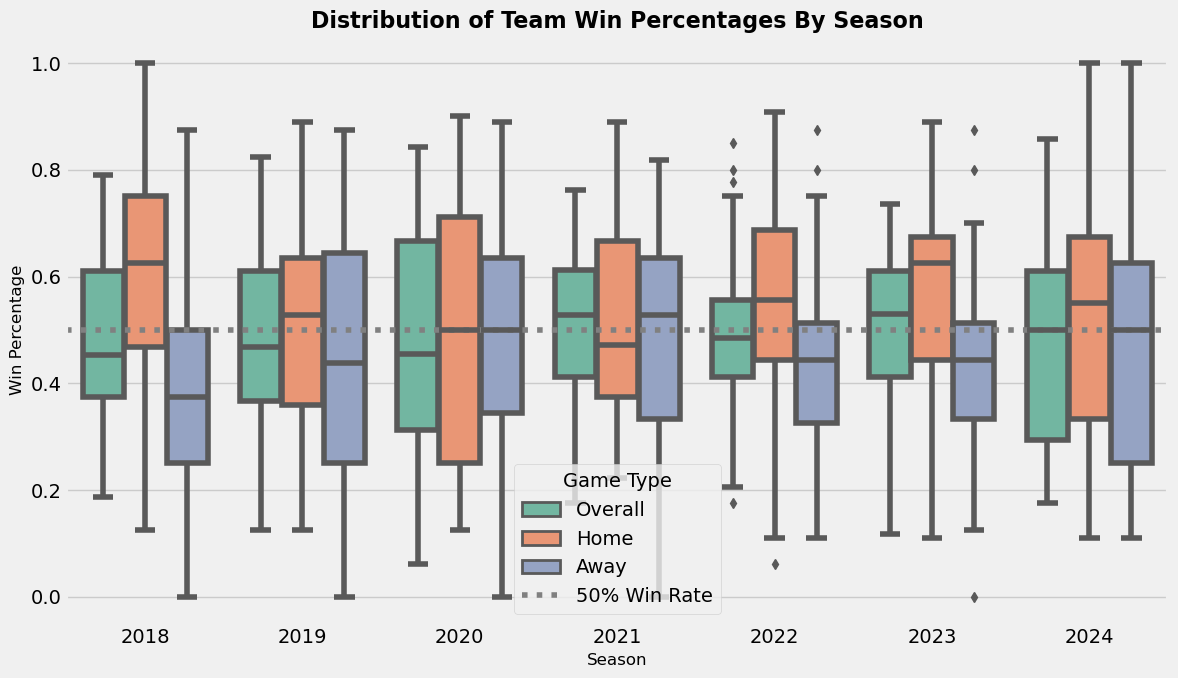

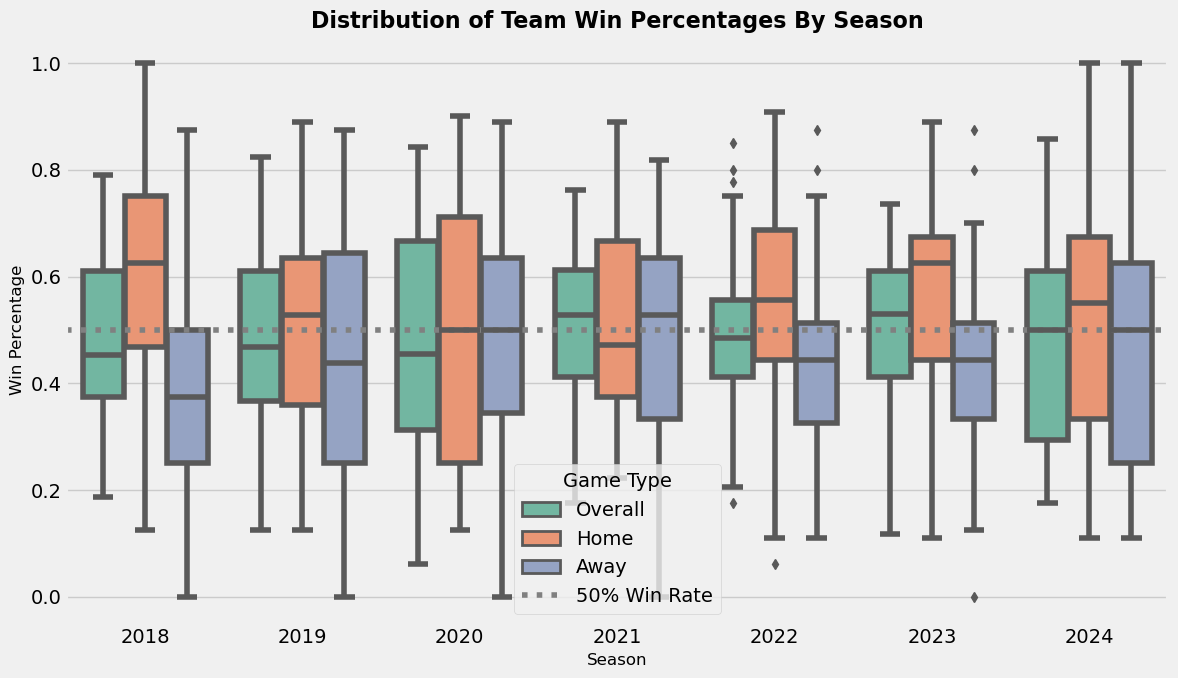


Generating 33 plots, one for each team...


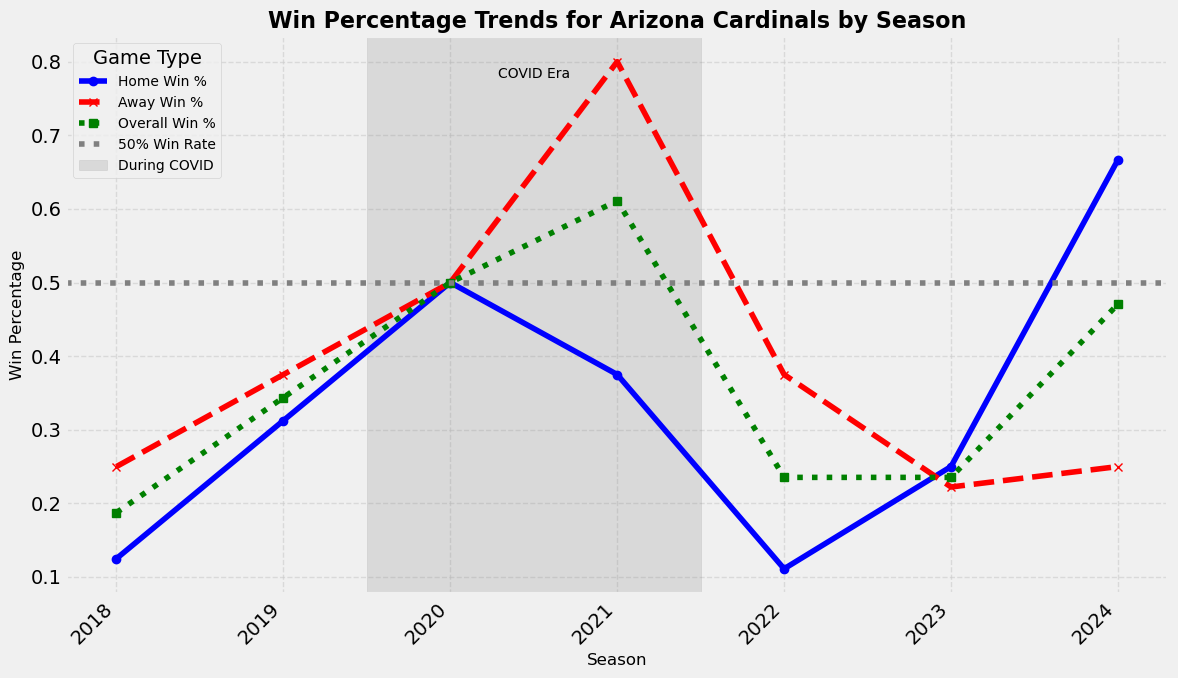

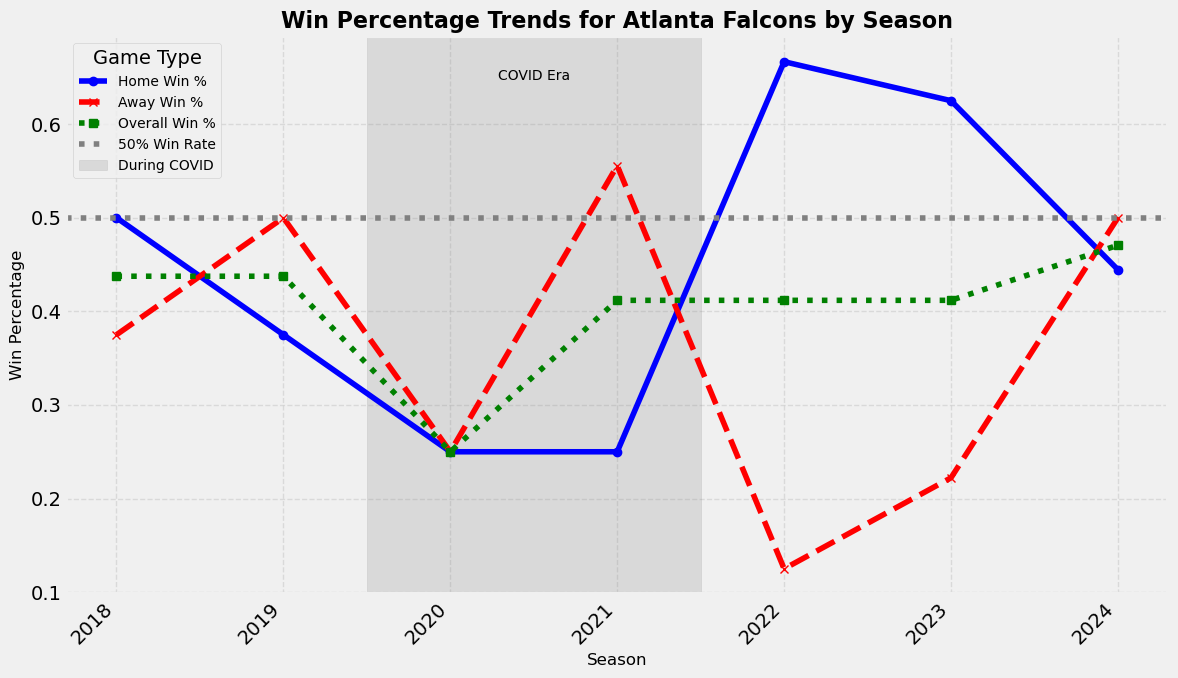

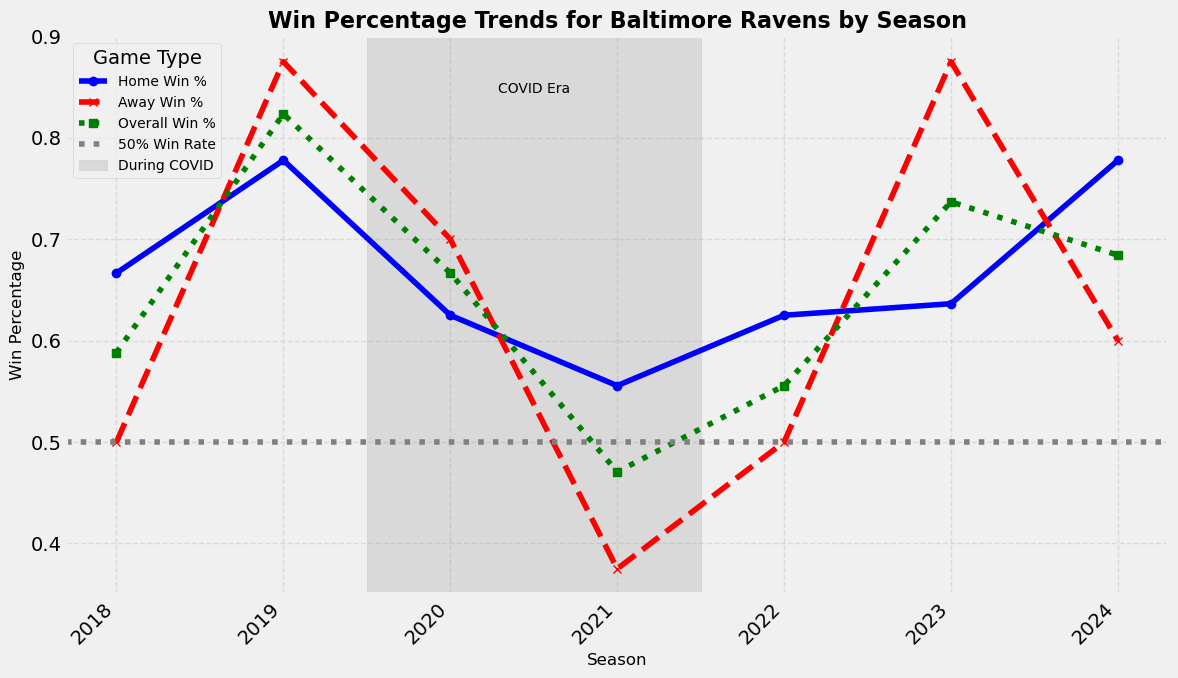

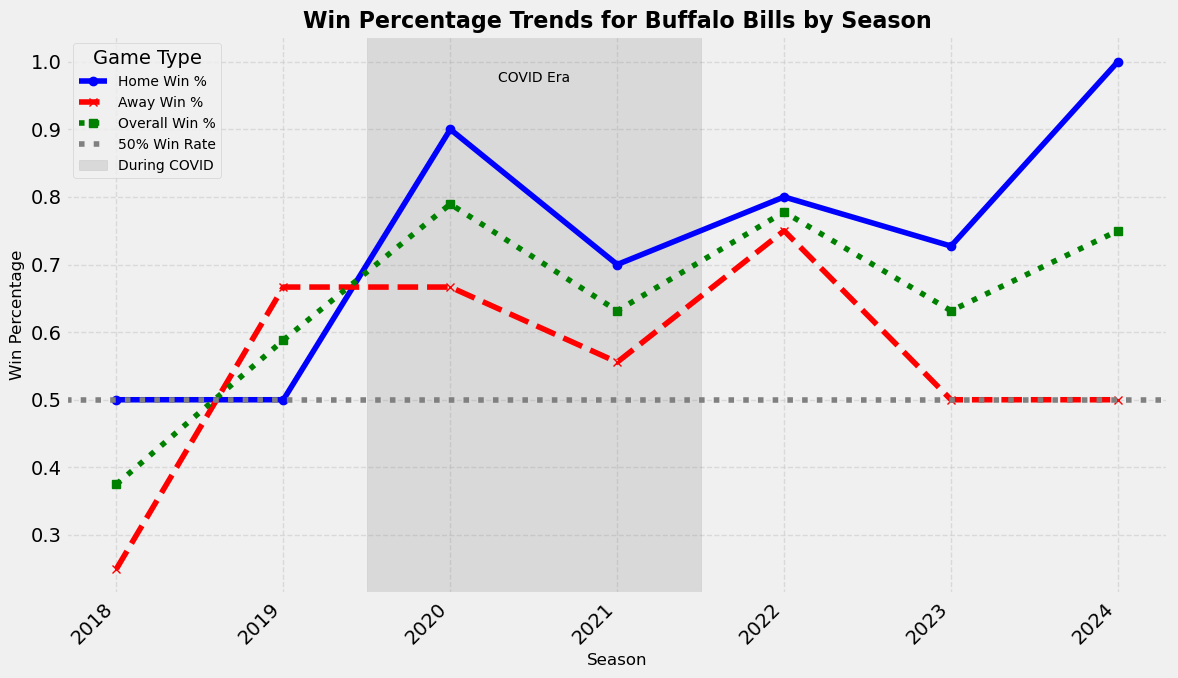

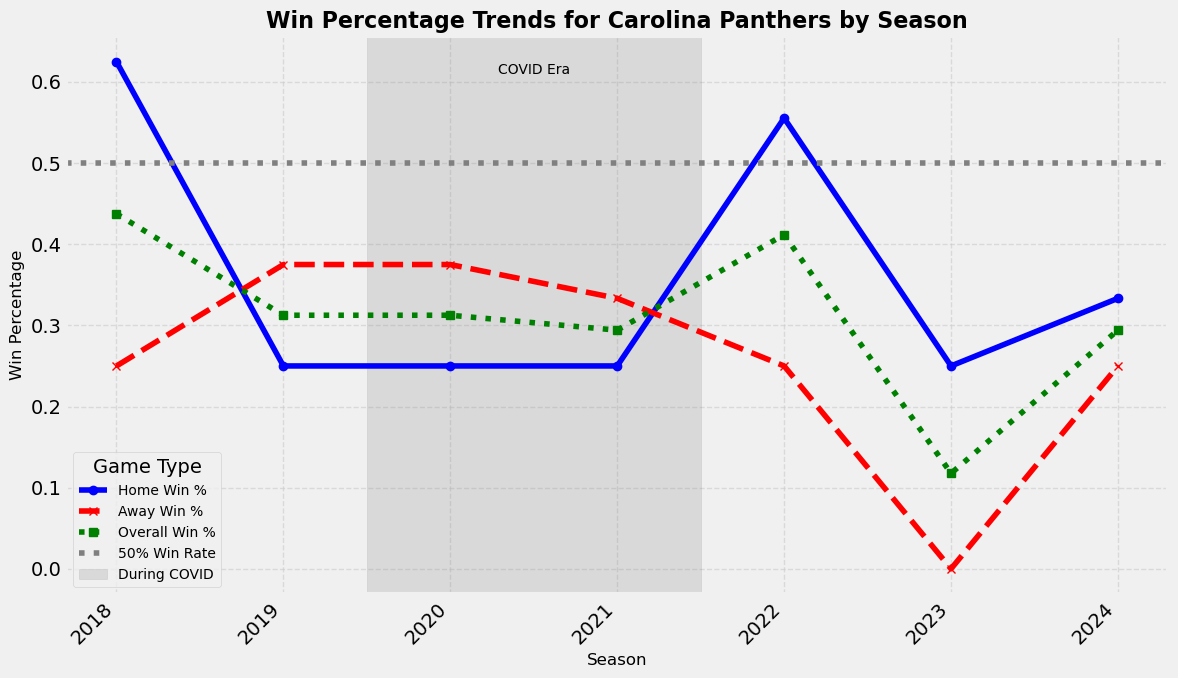

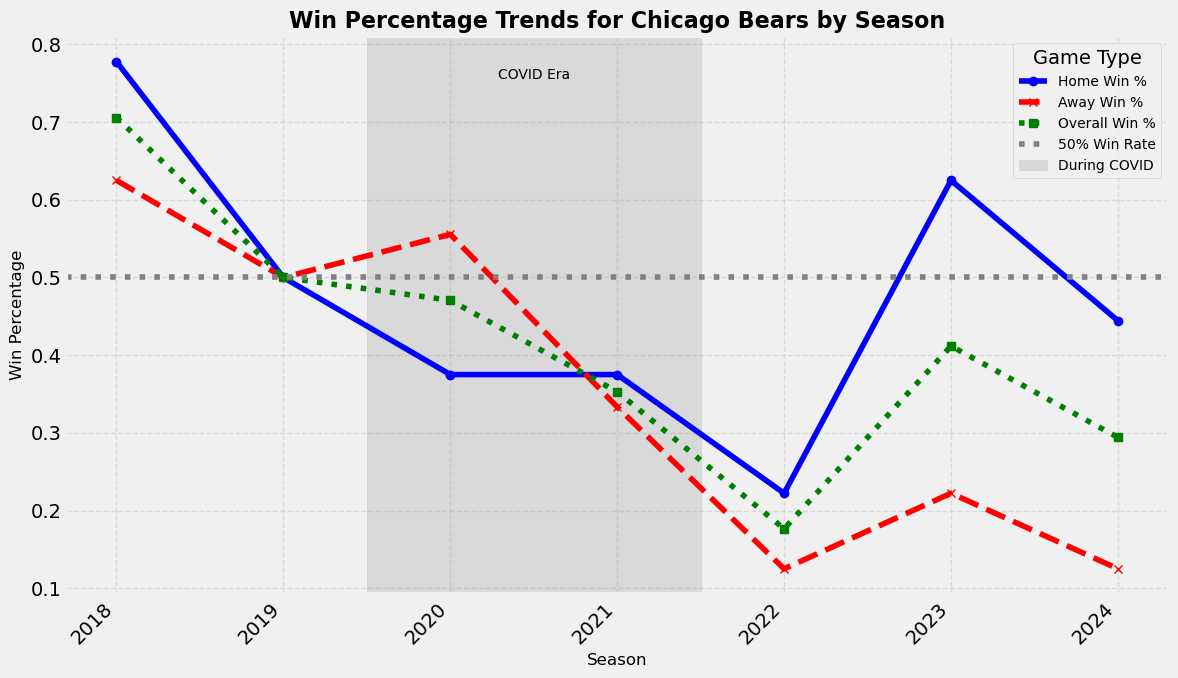

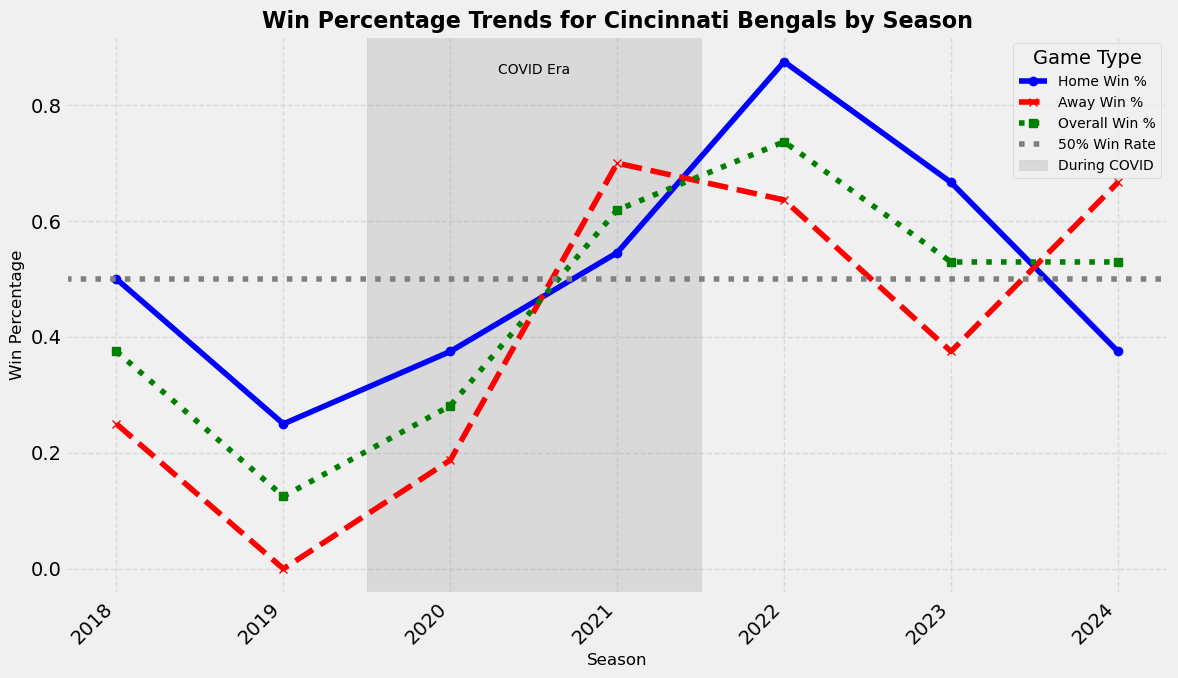

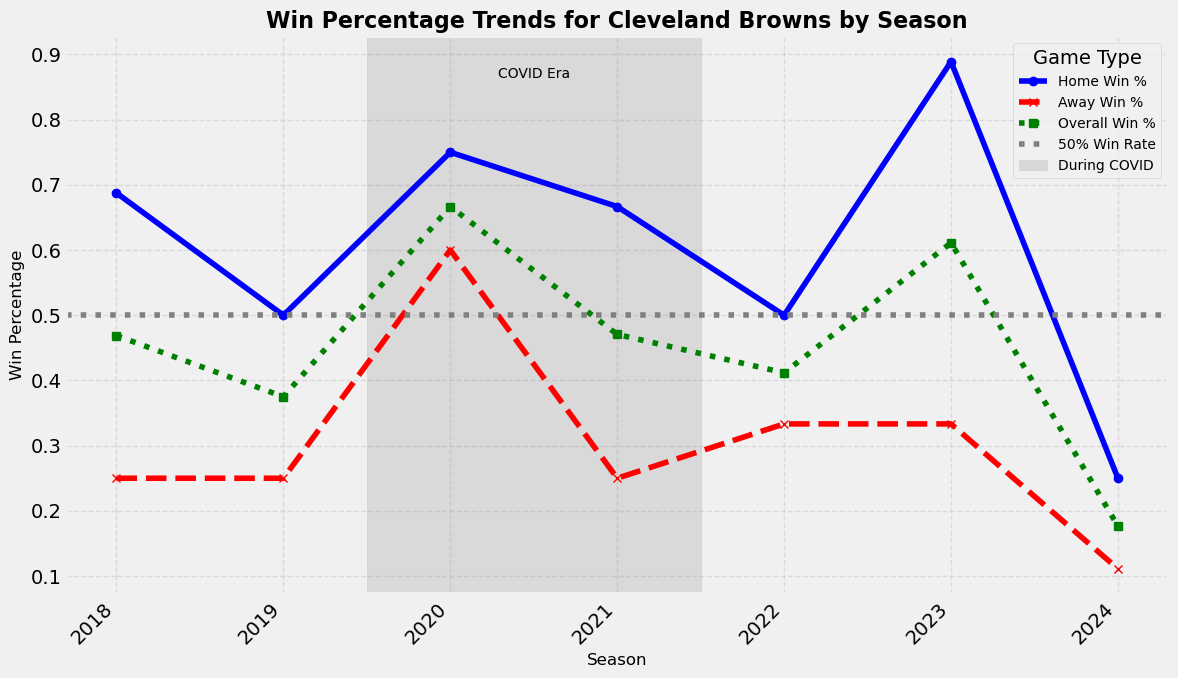

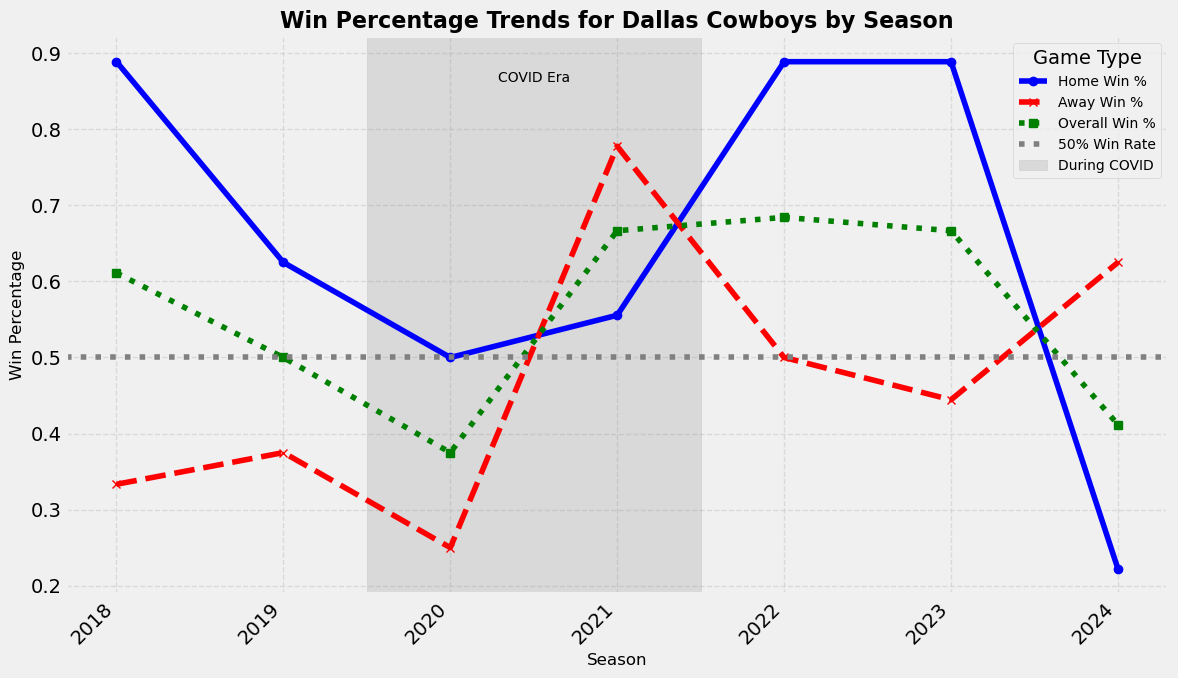

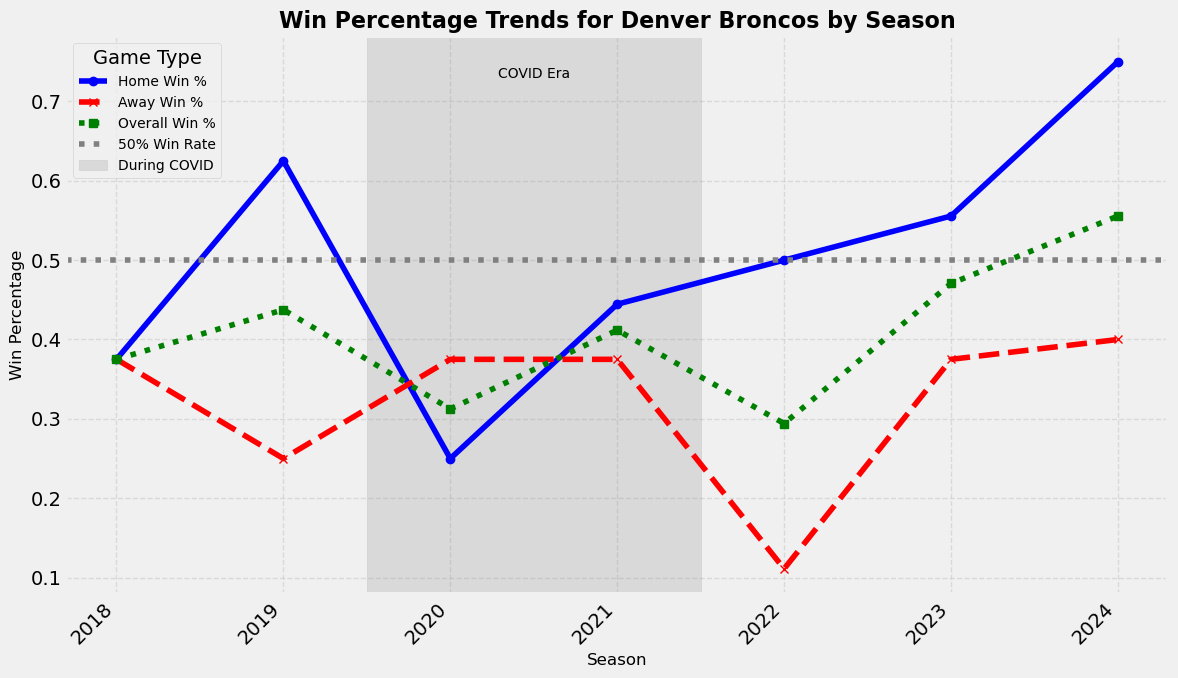

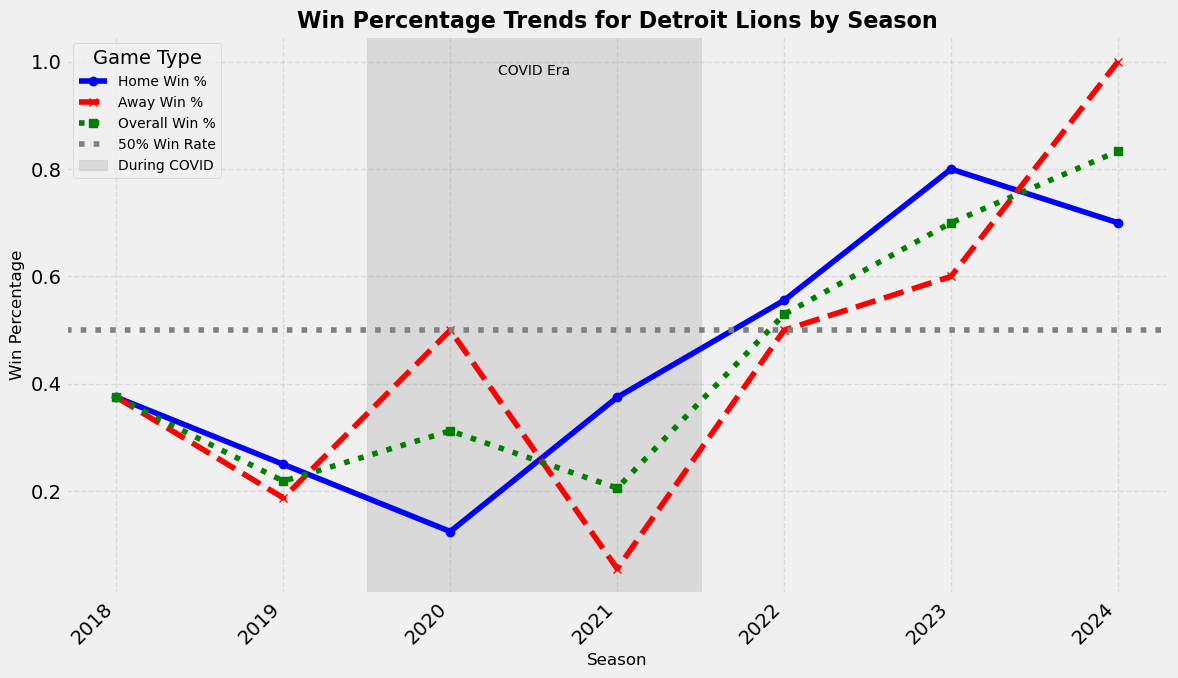

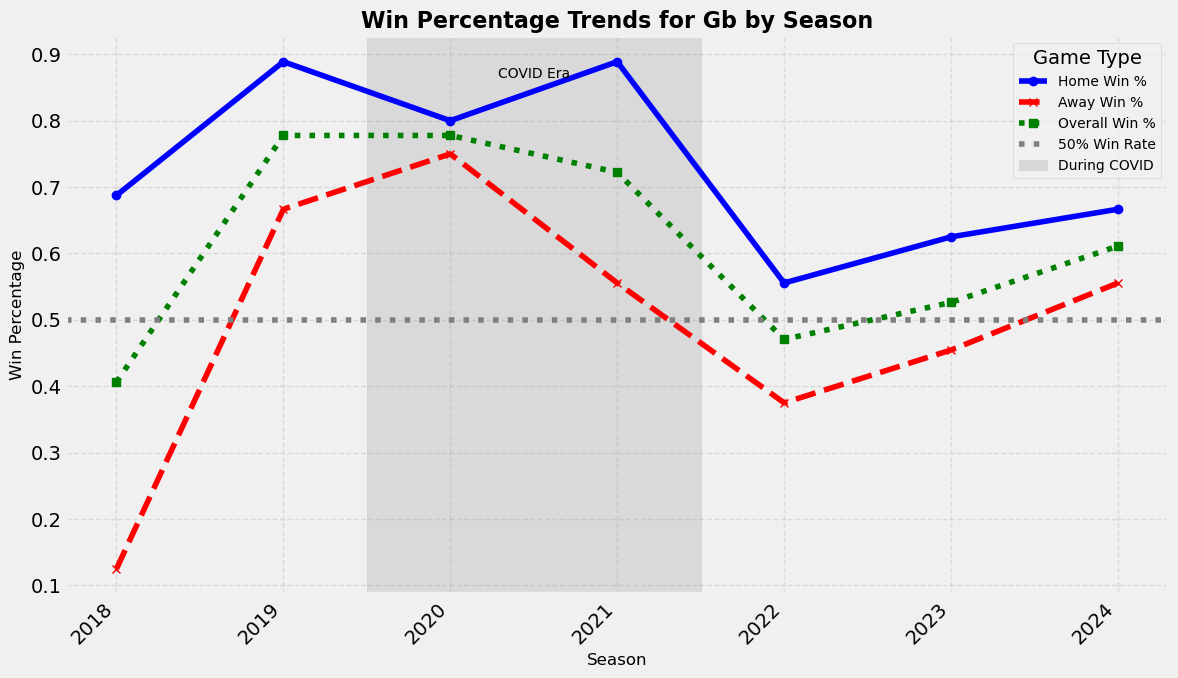

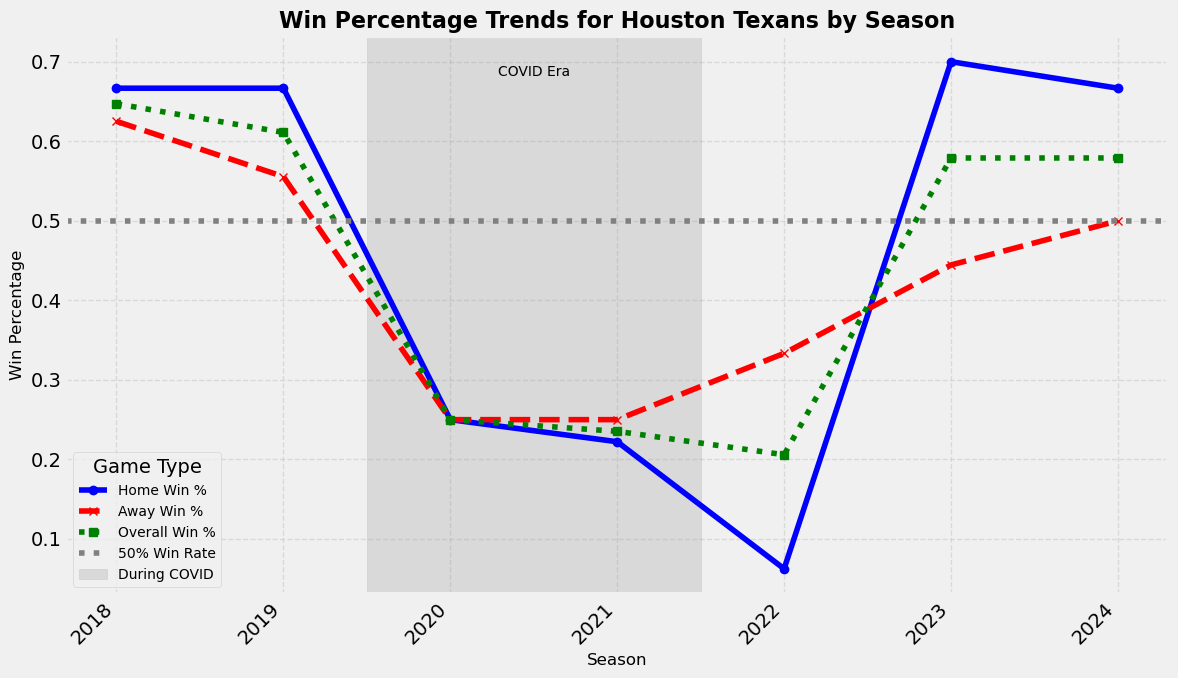

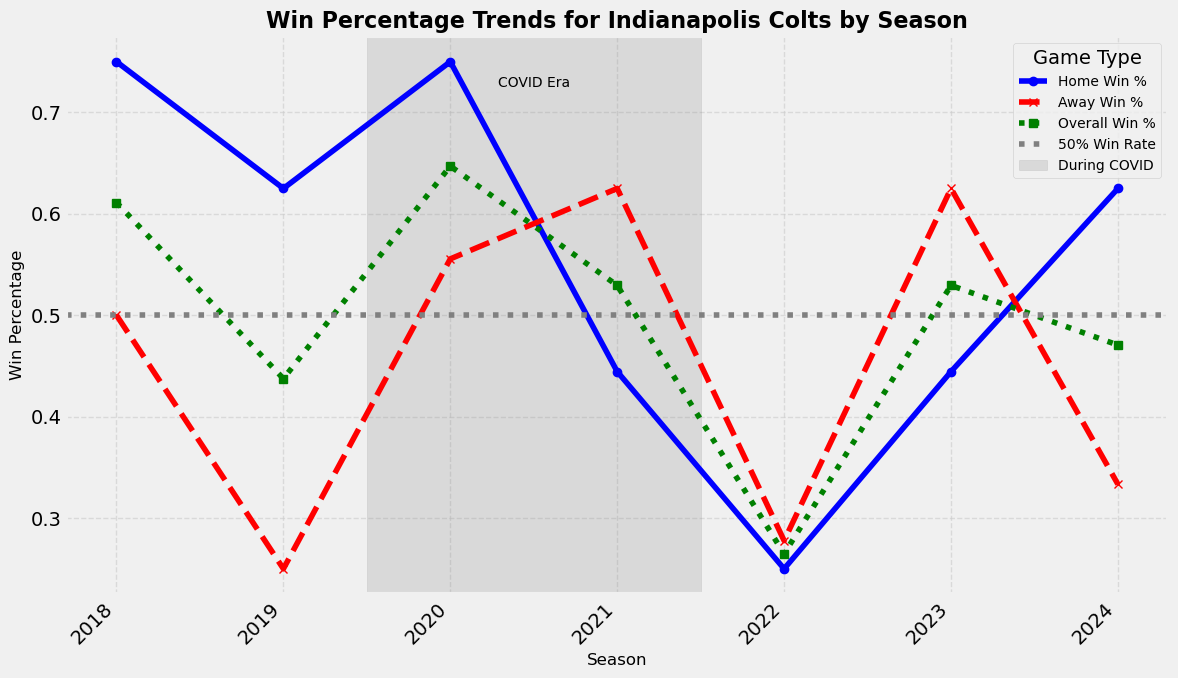

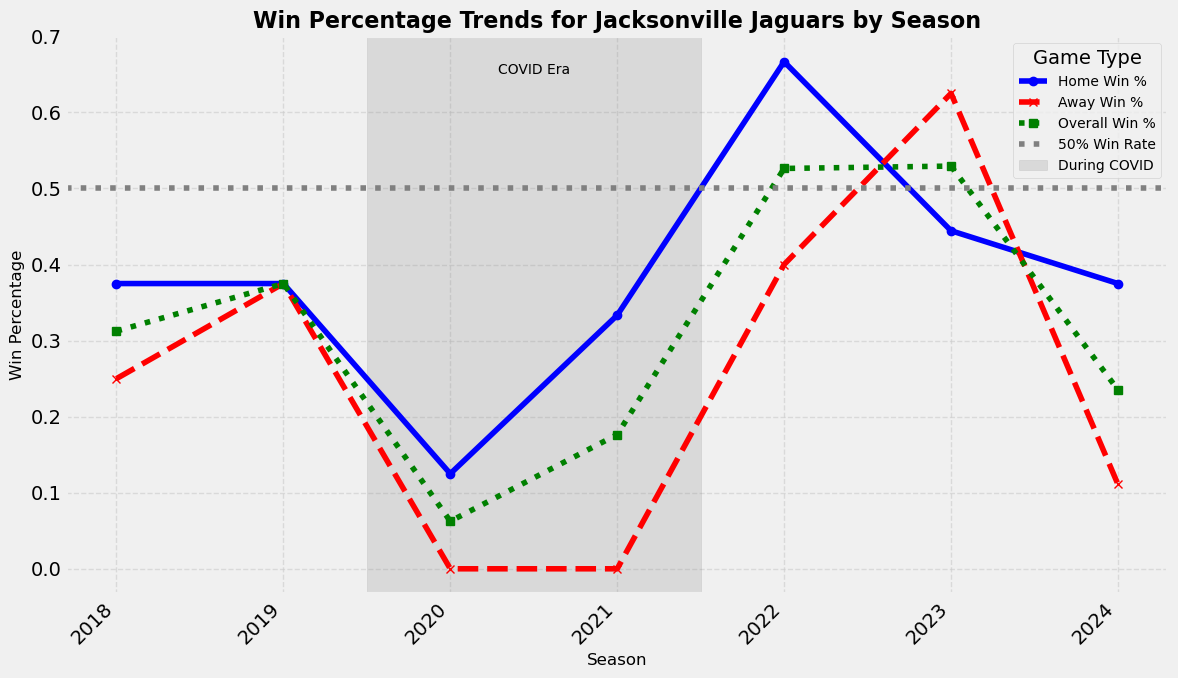

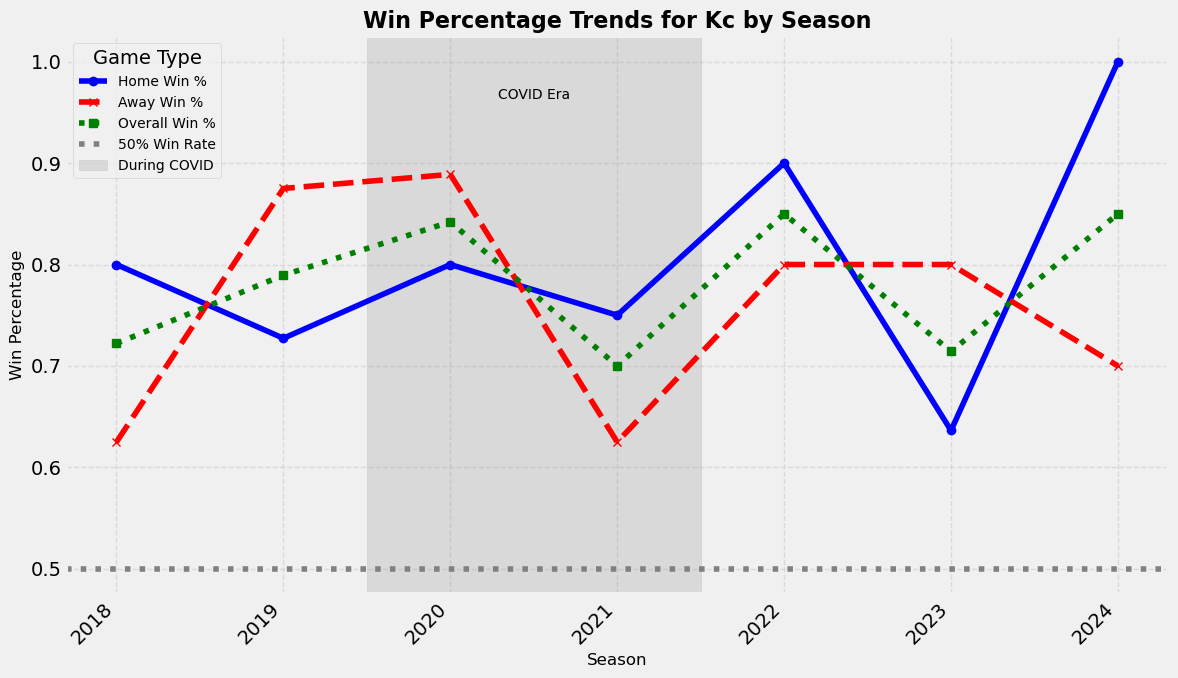

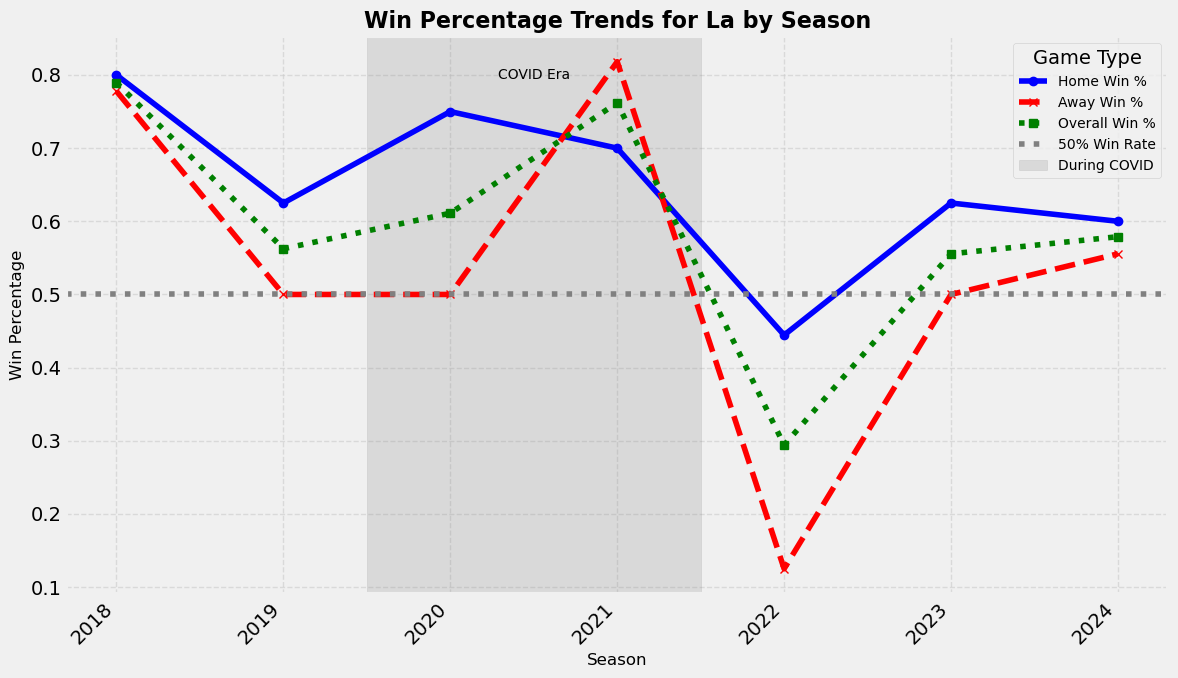

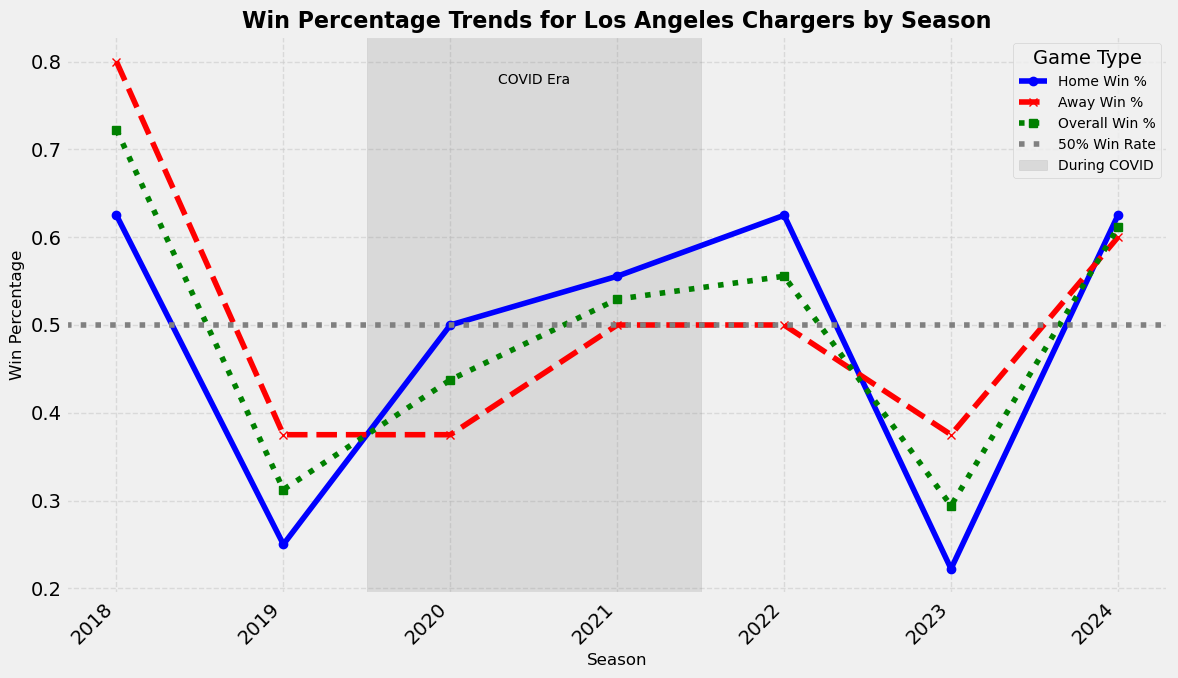

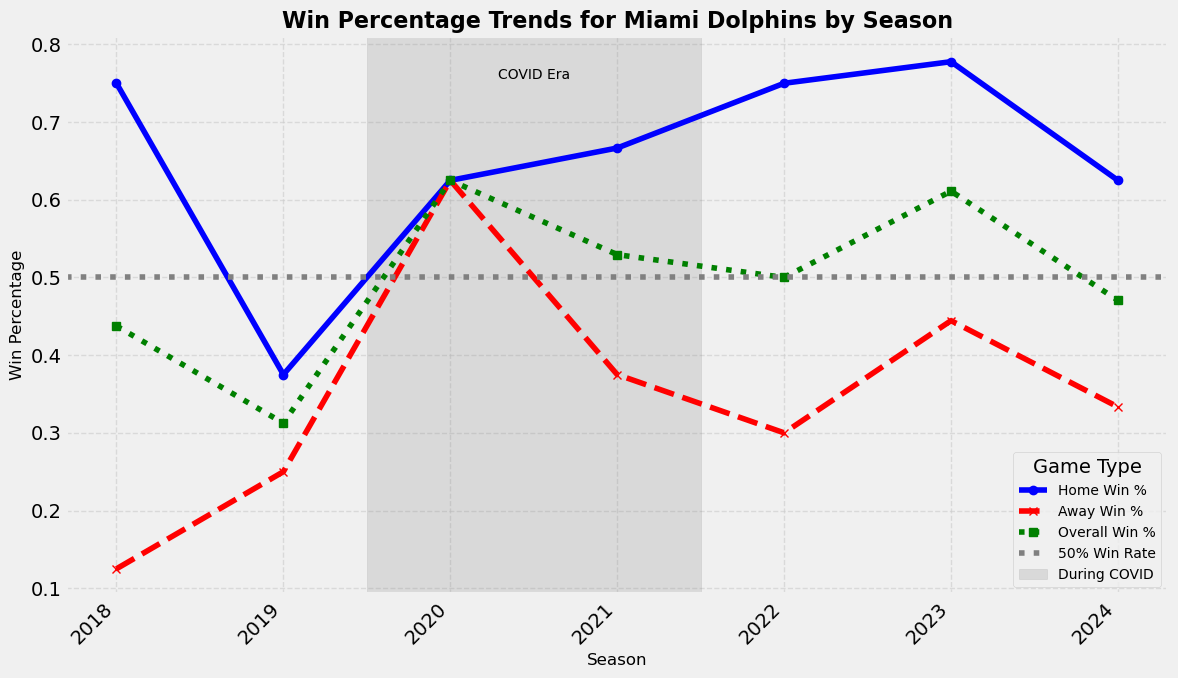

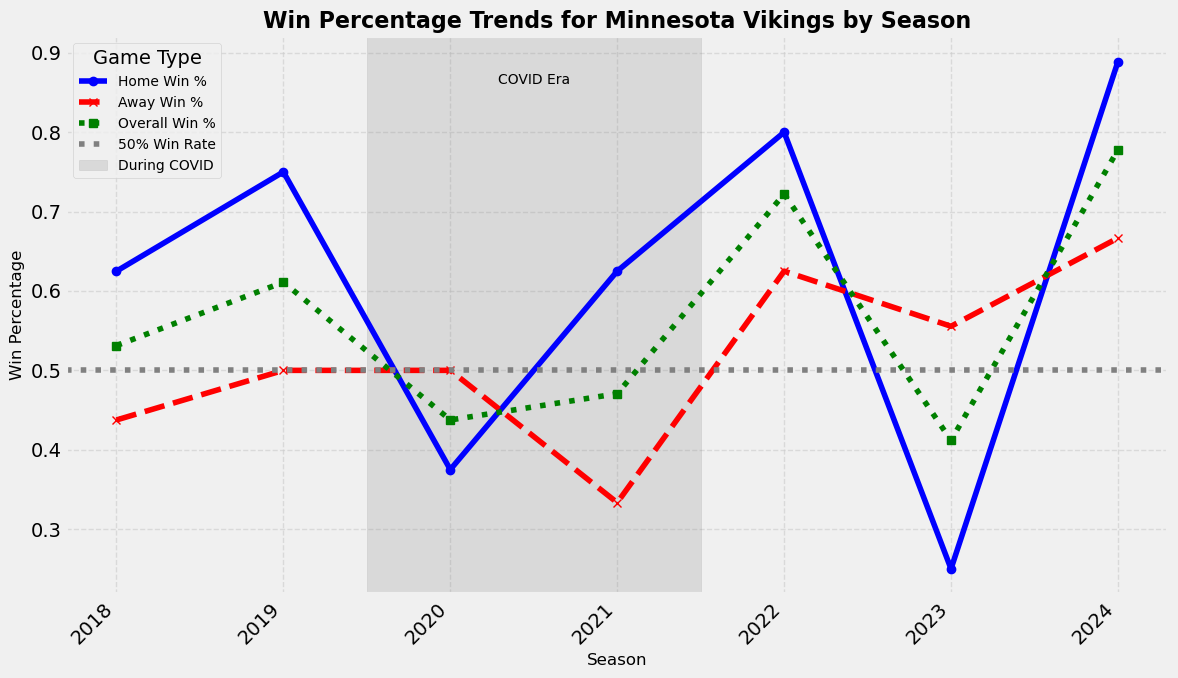

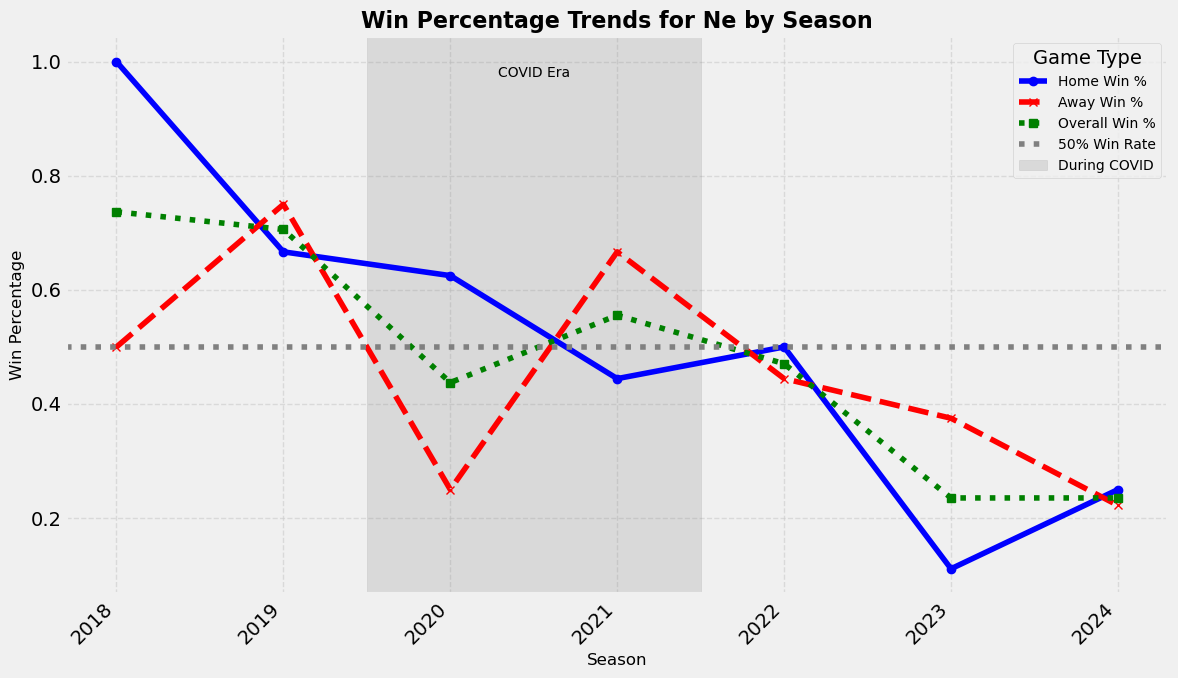

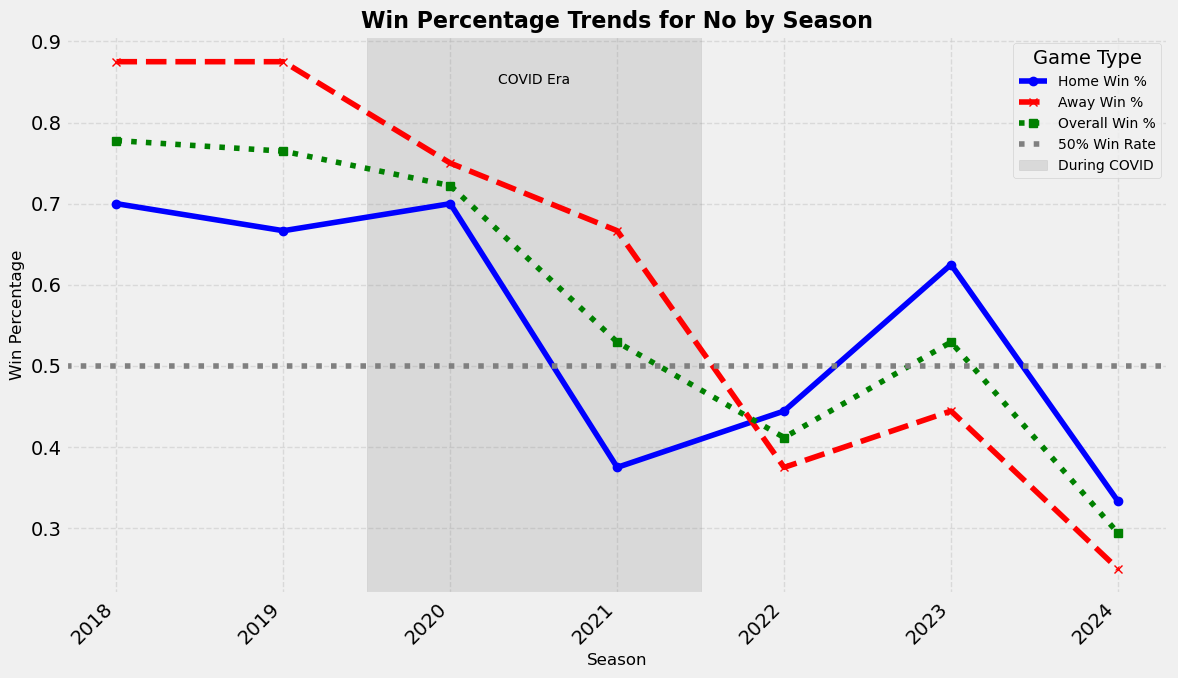

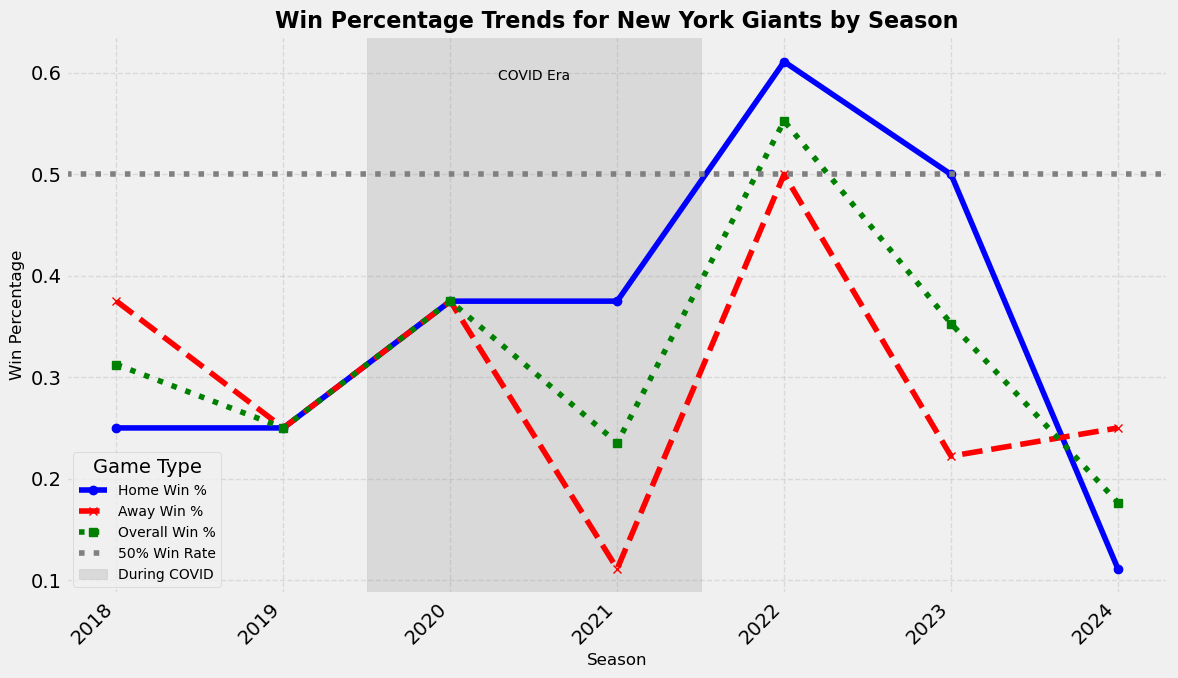

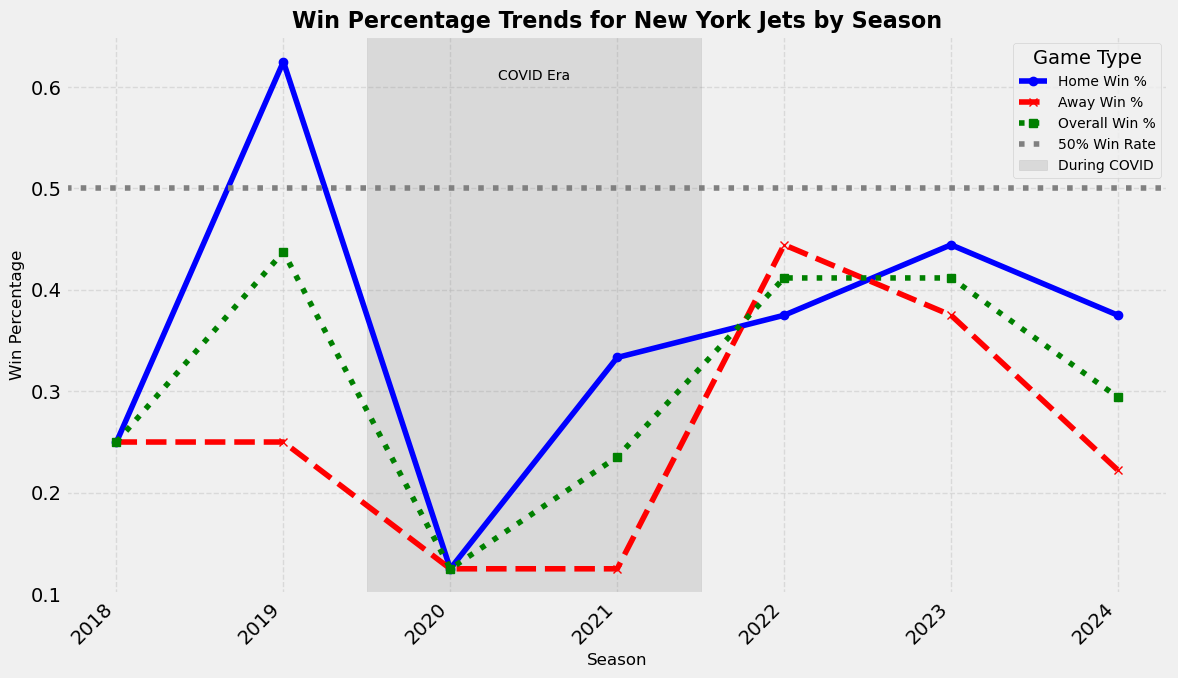

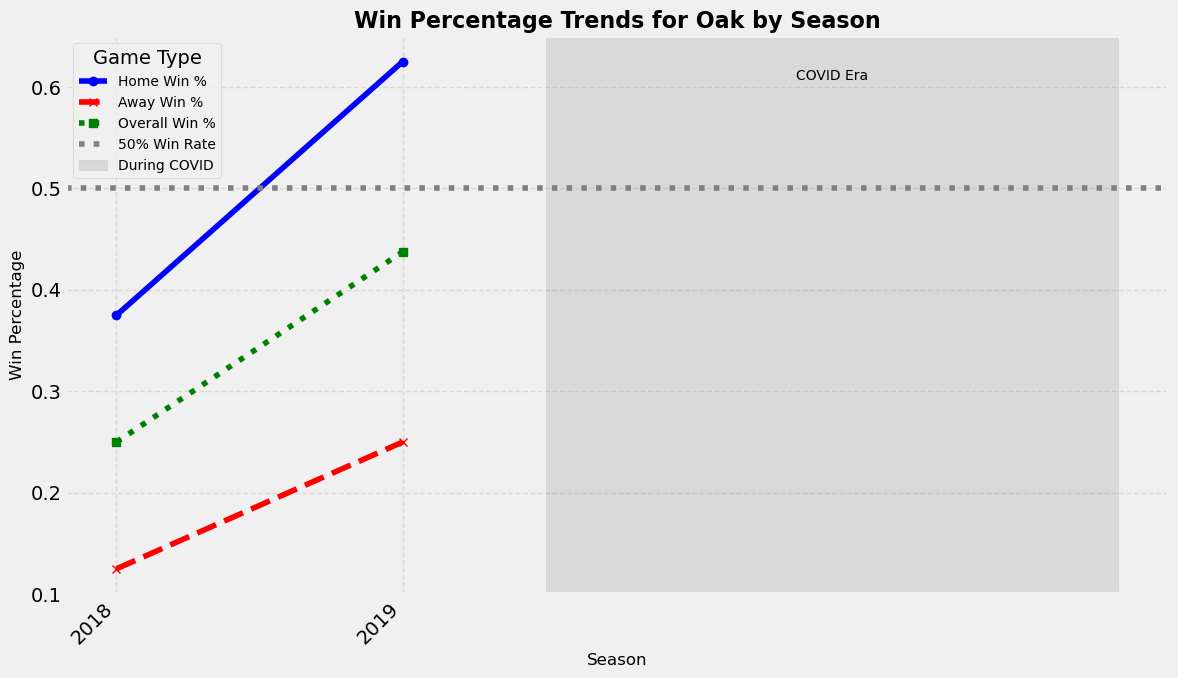

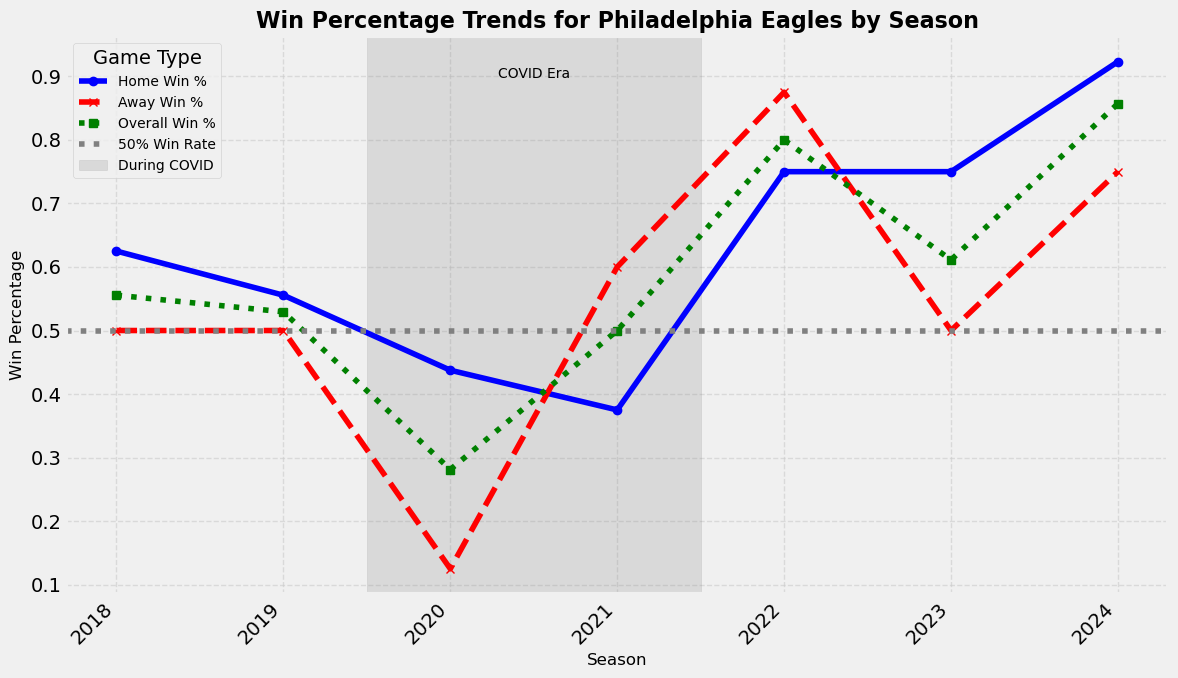

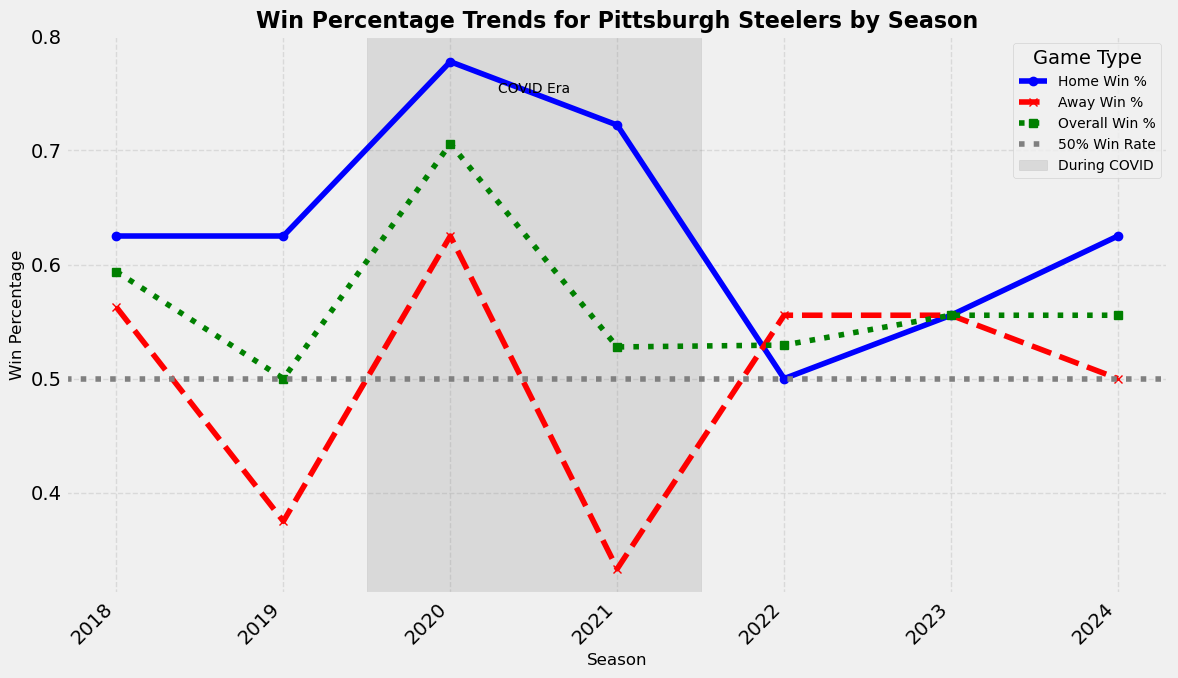

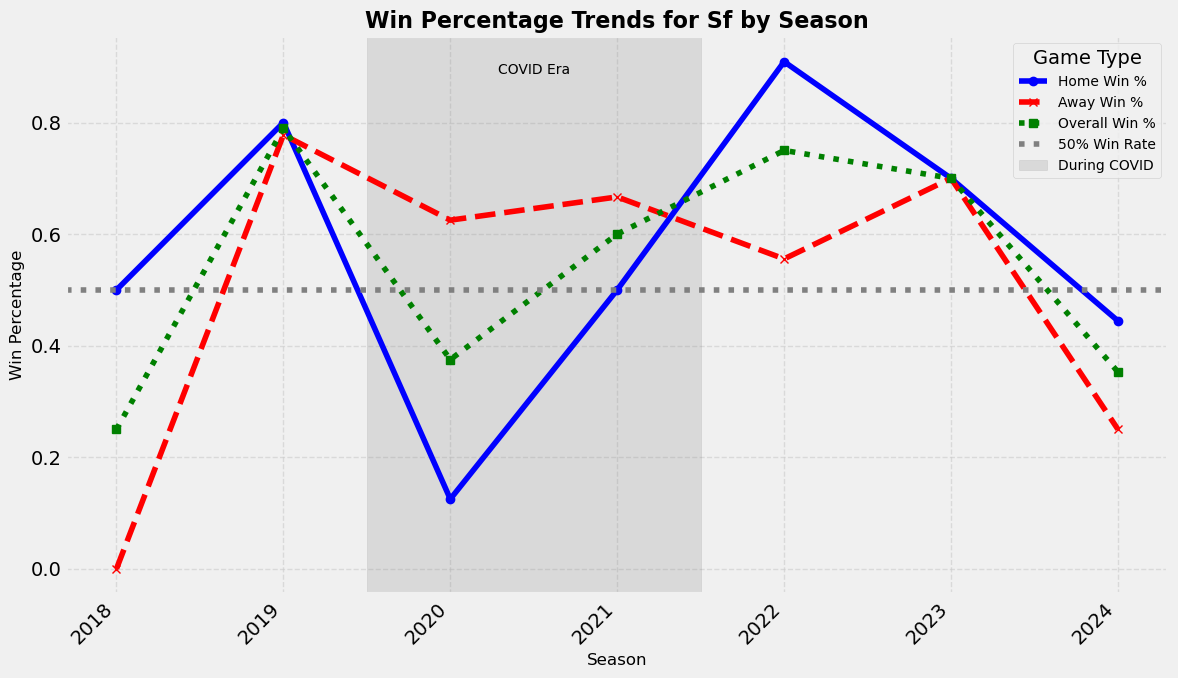

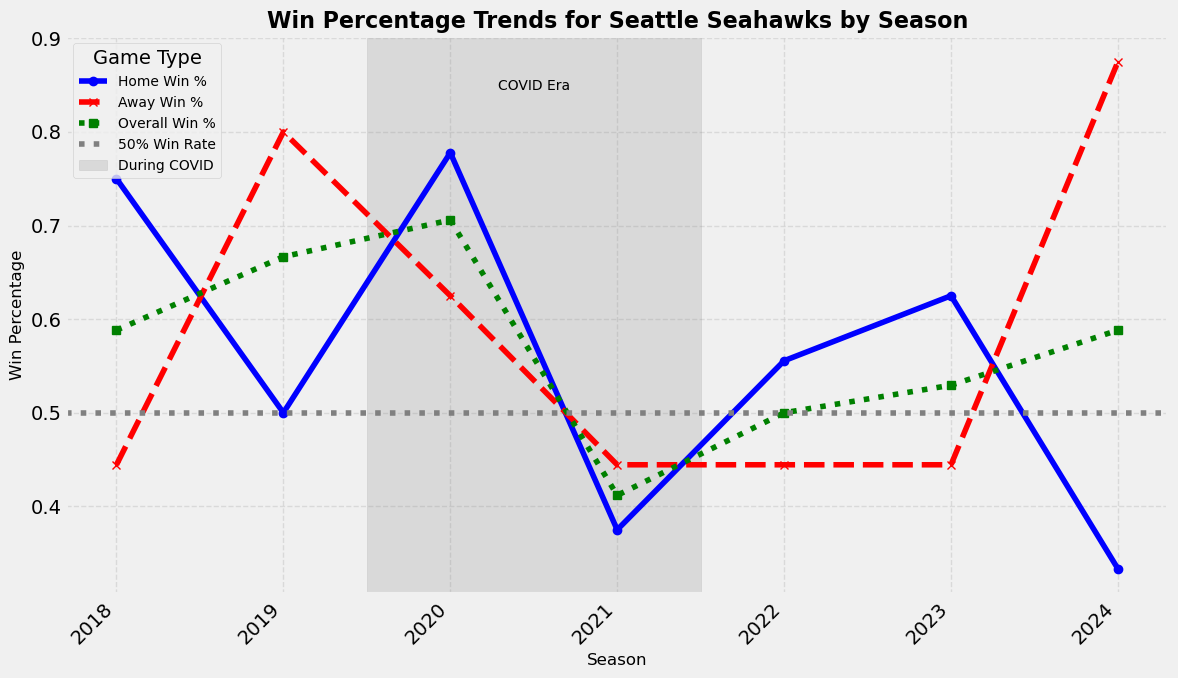

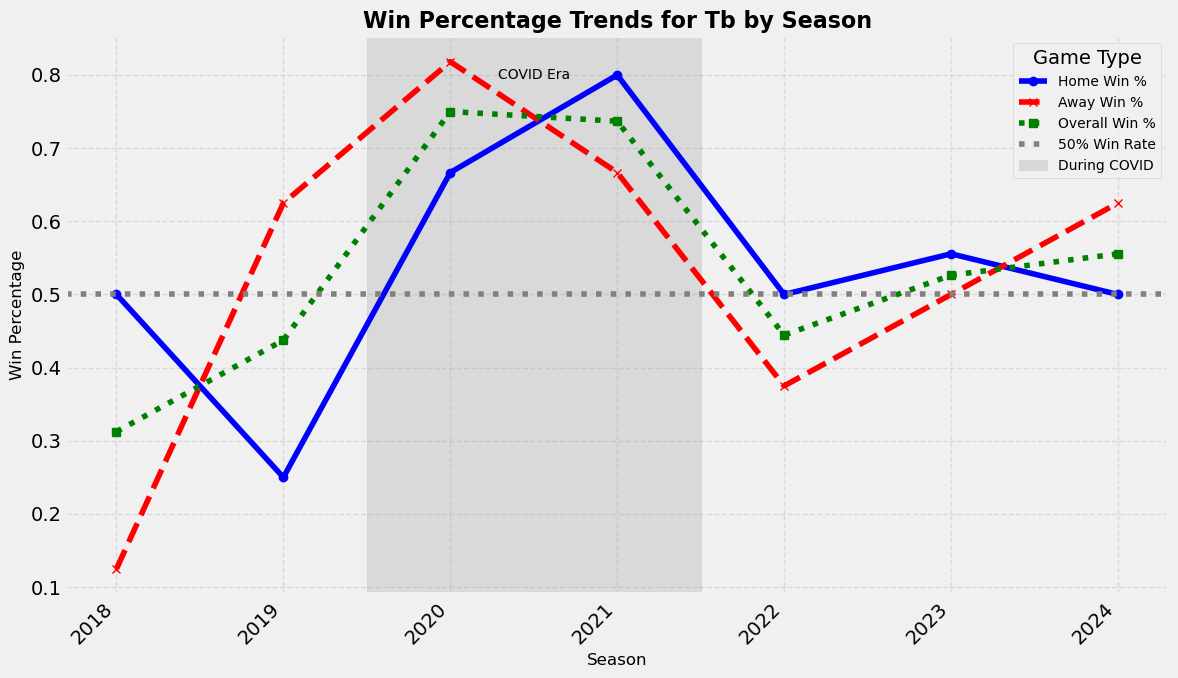

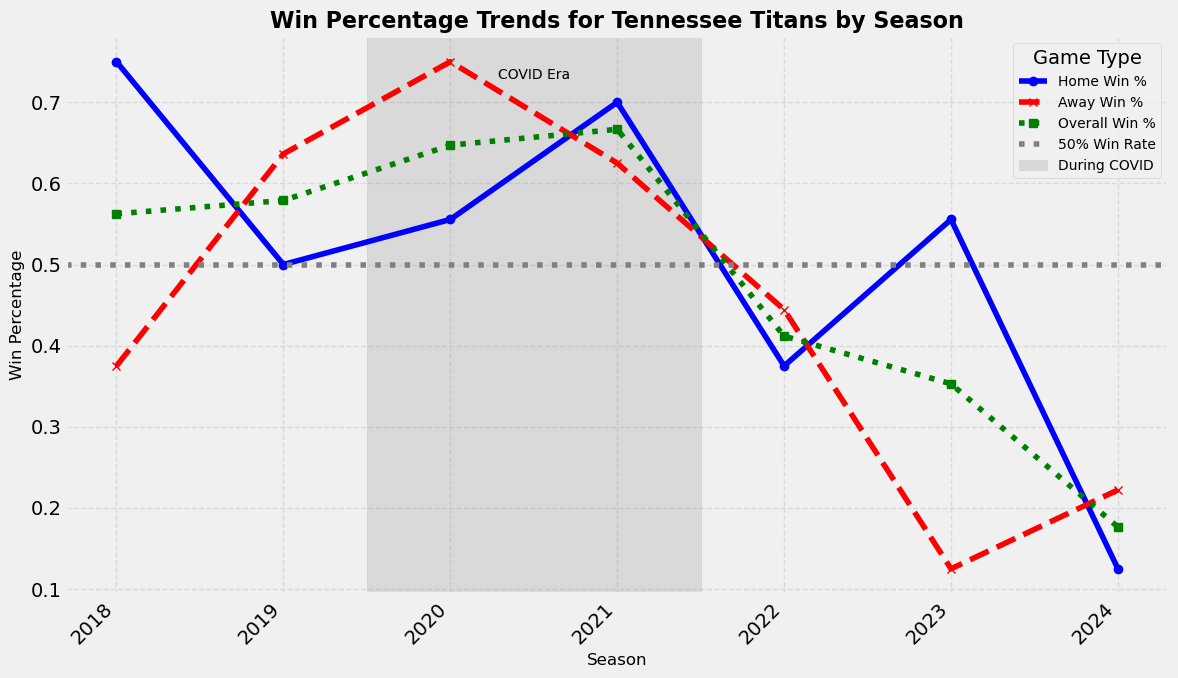

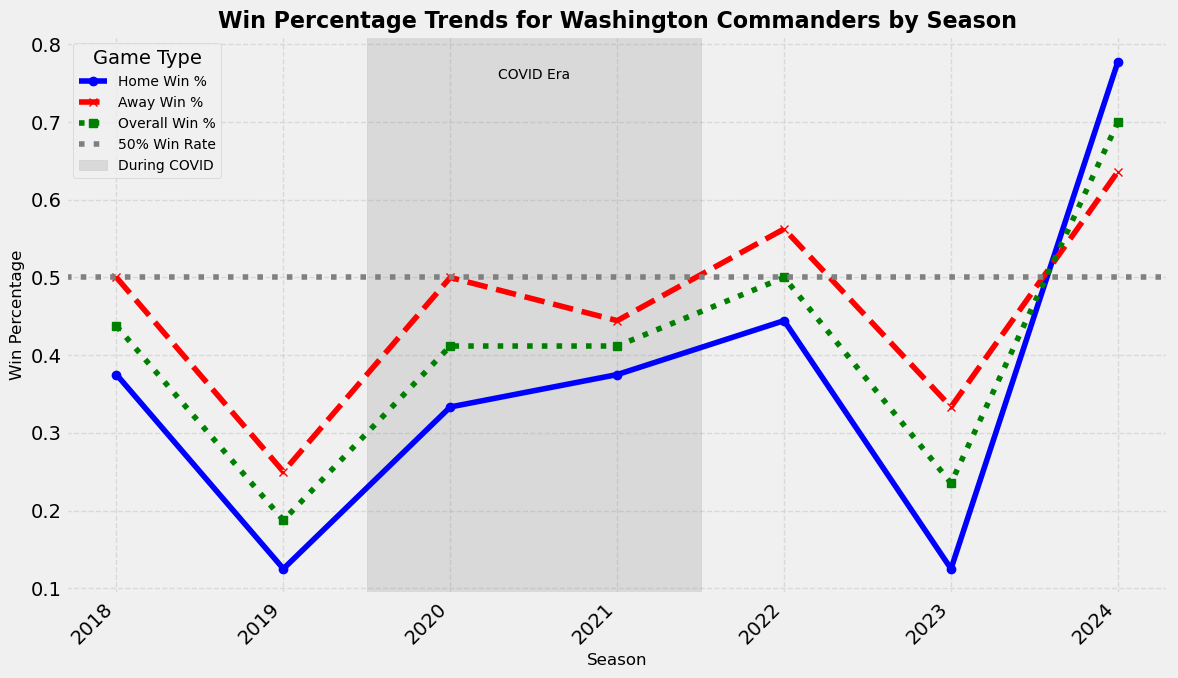

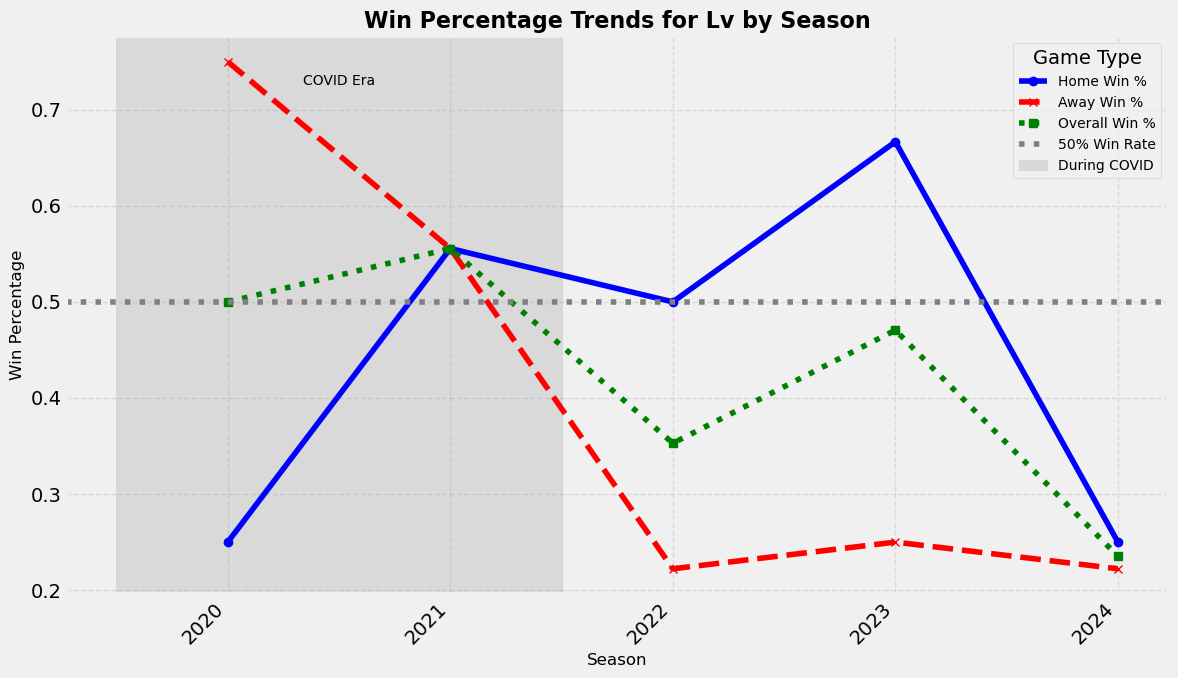

Plotted Per Team Win %


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
try:
    df = pd.read_csv('NFL_data.csv')
    #print("Data loaded successfully")
except FileNotFoundError:
    print("Unable to load data. Please ensure 'NFL_data.csv' is in the same directory.")
    exit()

#Clean Data
df.columns = df.columns.str.strip().str.lower()

# Calculate Home Wins, Away Wins, and Ties for all teams
home_summary = df.groupby(['year', 'covid_era', 'home_team']).agg(
    total_home_games=('winner', 'count'),
    home_wins=('winner', lambda x: (x == df.loc[x.index, 'home_team']).sum()),
    home_ties=('winner', lambda x: (x.str.lower() == 'tie').sum())
).reset_index().rename(columns={'home_team': 'team'})
home_summary['home_win_percentage'] = (home_summary['home_wins'] + (home_summary['home_ties'] * 0.5)) / home_summary['total_home_games']

away_summary = df.groupby(['year', 'covid_era', 'away_team']).agg(
    total_away_games=('winner', 'count'),
    away_wins=('winner', lambda x: (x == df.loc[x.index, 'away_team']).sum()),
    away_ties=('winner', lambda x: (x.str.lower() == 'tie').sum())
).reset_index().rename(columns={'away_team': 'team'})
away_summary['away_win_percentage'] = (away_summary['away_wins'] + (away_summary['away_ties'] * 0.5)) / away_summary['total_away_games']

# Calculate overall win percentage per COVID era for all teams
all_outcomes = pd.concat([
    df[['year', 'covid_era', 'home_team', 'winner']].rename(columns={'home_team': 'team'}),
    df[['year', 'covid_era', 'away_team', 'winner']].rename(columns={'away_team': 'team'})
], ignore_index=True)
all_outcomes['wins'] = np.where(all_outcomes['team'] == all_outcomes['winner'], 1, 0)
all_outcomes['ties'] = np.where(all_outcomes['winner'].str.lower() == 'tie', 1, 0)

overall_summary = all_outcomes.groupby(['year', 'covid_era', 'team']).agg(
    total_games=('wins', 'count'),
    total_wins=('wins', 'sum'),
    total_ties=('ties', 'sum')
).reset_index()
overall_summary['overall_win_percentage'] = (overall_summary['total_wins'] + (overall_summary['total_ties'] * 0.5)) / overall_summary['total_games']

# Print 
#print("\nSample of Team-Level Overall Win Percentages:")
print(overall_summary.head().to_string(index=False))

# Merge all win percentages into the original DataFrame and save
df_final = pd.merge(df, overall_summary[['year', 'team', 'overall_win_percentage']],
                    left_on=['year', 'home_team'], right_on=['year', 'team'], how='left')
df_final.rename(columns={'overall_win_percentage': 'home_team_overall_win_percentage'}, inplace=True)
df_final.drop(columns='team', inplace=True)

df_final = pd.merge(df_final, overall_summary[['year', 'team', 'overall_win_percentage']],
                    left_on=['year', 'away_team'], right_on=['year', 'team'], how='left')
df_final.rename(columns={'overall_win_percentage': 'away_team_overall_win_percentage'}, inplace=True)
df_final.drop(columns='team', inplace=True)

df_final = pd.merge(df_final, home_summary[['year', 'team', 'home_win_percentage']],
                    left_on=['year', 'home_team'], right_on=['year', 'team'], how='left')
df_final.rename(columns={'home_win_percentage': 'home_team_home_win_percentage'}, inplace=True)
df_final.drop(columns='team', inplace=True)

df_final = pd.merge(df_final, away_summary[['year', 'team', 'away_win_percentage']],
                    left_on=['year', 'away_team'], right_on=['year', 'team'], how='left')
df_final.rename(columns={'away_win_percentage': 'away_team_away_win_percentage'}, inplace=True)
df_final.drop(columns='team', inplace=True)

# Save to csv file
df_final.to_csv('NFL_data_win_percentages.csv', index=False)
print('\nFinal merged data saved to NFL_data_win_percentages.csv')

# Plot (Overall)
plotting_df = pd.DataFrame()
plotting_df = pd.concat([
    overall_summary.rename(columns={'overall_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Overall'),
    home_summary.rename(columns={'home_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Home'),
    away_summary.rename(columns={'away_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Away')
], ignore_index=True)

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(data=plotting_df, x='year', y='win_percentage', hue='type', ax=ax, palette='Set2')
ax.set_title('Distribution of Team Win Percentages By Season', fontsize=16, fontweight='bold')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Win Percentage', fontsize=12)
ax.axhline(y=0.5, color='gray', linestyle=':', label='50% Win Rate')
ax.legend(title='Game Type', loc='best')
plt.tight_layout()
plt.show()

#Plot (By Team)
# ... (Previous code for calculating win percentages is correct) ...

# Step 7: Visualize the distribution of win percentages (Overall)
plotting_df = pd.DataFrame()
plotting_df = pd.concat([
    overall_summary.rename(columns={'overall_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Overall'),
    home_summary.rename(columns={'home_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Home'),
    away_summary.rename(columns={'away_win_percentage': 'win_percentage'})[['year', 'win_percentage']].assign(type='Away')
], ignore_index=True)

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(data=plotting_df, x='year', y='win_percentage', hue='type', ax=ax, palette='Set2')
ax.set_title('Distribution of Team Win Percentages By Season', fontsize=16, fontweight='bold')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Win Percentage', fontsize=12)
ax.axhline(y=0.5, color='gray', linestyle=':', label='50% Win Rate')
ax.legend(title='Game Type', loc='best')
plt.tight_layout()
plt.show()

# Plot a separate graph for each team
all_team_stats = pd.merge(home_summary[['year', 'team', 'home_win_percentage']],
                          away_summary[['year', 'team', 'away_win_percentage']],
                          on=['year', 'team'], how='outer')
all_team_stats = pd.merge(all_team_stats, overall_summary[['year', 'team', 'overall_win_percentage']],
                          on=['year', 'team'], how='outer')

plt.style.use('fivethirtyeight')
unique_teams = all_team_stats['team'].unique()
print(f"\nGenerating {len(unique_teams)} plots, one for each team...")

for team in unique_teams:
    team_data = all_team_stats[all_team_stats['team'] == team].sort_values('year')
    if team_data.empty:
        continue

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(team_data['year'], team_data['home_win_percentage'], marker='o', label='Home Win %', color='blue')
    ax.plot(team_data['year'], team_data['away_win_percentage'], marker='x', label='Away Win %', color='red', linestyle='--')
    ax.plot(team_data['year'], team_data['overall_win_percentage'], marker='s', label='Overall Win %', color='green', linestyle=':')

    ax.set_title(f'Win Percentage Trends for {team.title()} by Season', fontsize=16, fontweight='bold')
    ax.set_xlabel('Season', fontsize=12)
    ax.set_ylabel('Win Percentage', fontsize=12)
    ax.set_xticks(team_data['year'].unique())
    ax.set_xticklabels(team_data['year'].unique(), rotation=45, ha='right')
    ax.axhline(y=0.5, color='gray', linestyle=':', label='50% Win Rate')

    if 'covid_era' in df.columns:
        covid_years = df[df['covid_era'] == 'During_COVID']['year'].unique()
        if len(covid_years) > 0:
            min_covid_year = min(covid_years)
            max_covid_year = max(covid_years)
            ax.axvspan(min_covid_year - 0.5, max_covid_year + 0.5, color='gray', alpha=0.2, label='During COVID')
            ax.text(min_covid_year + 0.5, ax.get_ylim()[1] * 0.95, 'COVID Era', ha='center', va='top', fontsize=10, color='black')

    ax.legend(title='Game Type', loc='best', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
print('Plotted Per Team Win %')

In [6]:
#Test The Significance of Crowd Change
import pandas as pd
import statsmodels.api as sm 

#Load Dataset
try:
    df = pd.read_csv('NFL_data_win_percentages.csv')
    #print("Data loaded")
except FileNotFoundError:
    print("Unable to read in file.")
    exit()

#Standarized column names 
df.columns = df.columns.str.strip().str.lower()

#Agregate data for testing 
regression_df  = df.groupby(['year', 'home_team', 'covid_era',]).agg(
    mean_home_win_percentage=('home_team_home_win_percentage', 'mean'), 
    mean_attendance=('attendance', 'mean')
).reset_index()

#Drop missing values 
regression_df = regression_df.dropna()
#print("Running multiple linear regressions to test attendance and covid era impact on home field advantage.")

#covid-era vairables
regression_df['covid_era'] = regression_df['covid_era'].str.lower()
regression_df = pd.get_dummies(regression_df, columns=['covid_era'], drop_first=True, dtype=int)


#Define dependent and independent variables 
y = regression_df['mean_home_win_percentage']
x = regression_df[['mean_attendance', 'covid_era_post_covid', 'covid_era_pre_covid']]

x = sm.add_constant(x)

#Fit linear regression model
model = sm.OLS(y, x).fit()

#Print results
print("Linear regression summary: ")
print(model.summary())

#Print key findings 
print("For mean_attendance and covid-era a p-value < 0.05 indicts a signficant relationship to winning percentage.")
print("mena_attendance can salso share if crowd size has a large impact on win % at home")


Linear regression summary: 
                               OLS Regression Results                               
Dep. Variable:     mean_home_win_percentage   R-squared:                       0.025
Model:                                  OLS   Adj. R-squared:                  0.006
Method:                       Least Squares   F-statistic:                     1.289
Date:                      Fri, 05 Sep 2025   Prob (F-statistic):              0.280
Time:                              14:42:51   Log-Likelihood:                 26.680
No. Observations:                       155   AIC:                            -45.36
Df Residuals:                           151   BIC:                            -33.19
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [8]:
#Test The Significance of Crowd Change
import pandas as pd
import statsmodels.api as sm 

#Load Dataset
try:
    df = pd.read_csv('NFL_data_win_percentages.csv')
    print("Data loaded")
except FileNotFoundError:
    print("Unable to read in file.")
    exit()

#Standarized column names 
df.columns = df.columns.str.strip().str.lower()

#Agregate data for testing 
regression_df  = df.groupby(['year', 'home_team', 'covid_era',]).agg(
    mean_home_win_percentage=('home_team_home_win_percentage', 'mean'), 
    mean_attendance=('attendance', 'mean')
).reset_index()

#Drop missing values 
regression_df = regression_df.dropna()
#print("Running multiple linear regressions to test attendance and covid era impact on home field advantage.")

#covid-era vairables
regression_df['covid_era'] = regression_df['covid_era'].str.lower().str.replace('_', '')
regression_df = pd.get_dummies(regression_df, columns=['covid_era'], drop_first=True, dtype=int)


#Define dependent and independent variables 
y = regression_df['mean_home_win_percentage']
x = regression_df[['covid_era_postcovid', 'covid_era_precovid']]

x = sm.add_constant(x)

#Fit linear regression model
model = sm.OLS(y, x).fit()

#Print results
print("Linear regression summary: ")
print(model.summary())

#Print key findings 
print("For mean_attendance and covid-era a p-value < 0.05 indicts a signficant relationship to winning percentage.")
print("mena_attendance can salso share if crowd size has a large impact on win % at home")


Data loaded
Linear regression summary: 
                               OLS Regression Results                               
Dep. Variable:     mean_home_win_percentage   R-squared:                       0.022
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     1.712
Date:                      Fri, 05 Sep 2025   Prob (F-statistic):              0.184
Time:                              14:43:05   Log-Likelihood:                 26.447
No. Observations:                       155   AIC:                            -46.89
Df Residuals:                           152   BIC:                            -37.76
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------